## 🌐 **Google Drive and Kaggle Connection**

In [10]:
# Install and configure Kaggle API
!pip install -q kaggle

import os
from google.colab import drive
from google.colab import files

# --- Configuration ---
# Percorso di destinazione sul Drive
DRIVE_MOUNT_PATH = "/content/gdrive"
DATASET_PATH = f"{DRIVE_MOUNT_PATH}/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset"
COMPETITION_ID = "an2dl2526c2v2"
ZIP_FILENAME = f"{COMPETITION_ID}.zip"
EXPECTED_ZIP_FILE = os.path.join(DATASET_PATH, ZIP_FILENAME)

# --- 1. Mount Google Drive ---
print("1. Mounting Google Drive...")
# Mount G-Drive if it's not already mounted
if not os.path.exists(DRIVE_MOUNT_PATH):
    drive.mount(DRIVE_MOUNT_PATH)
else:
    print("Drive already mounted.")

# --- 2. Check for Existing Data ---
if os.path.exists(EXPECTED_ZIP_FILE):
    print(f"\n✅ Dataset found at {DATASET_PATH}. Skipping download and setup.")
    # You can also add a check here for the unzipped folders if you prefer.
else:
    # --- 3. Setup Kaggle Credentials (Only if download is needed) ---
    print("\n⏳ Dataset not found. Starting Kaggle setup and download.")

    # 3a. Upload kaggle.json
    print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")

    # Check if files.upload() returned a file (if running interactively)
    # The uploaded dictionary keys are the filenames.
    uploaded = files.upload()

    if "kaggle.json" in uploaded:
        # 3b. Configura le credenziali
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle credentials configured.")

        # 3c. Create destination folder and Download
        !mkdir -p {DATASET_PATH}
        print(f"Downloading dataset to: {DATASET_PATH}")
        # Scarica il dataset direttamente da Kaggle nella cartella scelta
        !kaggle competitions download -c {COMPETITION_ID} -p {DATASET_PATH}

    else:
        print("\n⚠️ kaggle.json not uploaded. Cannot proceed with download.")


# --- 4. Decompress Data (Always check for existence before unzipping) ---

EXPECTED_UNZIPPED_FILE = os.path.join(DATASET_PATH, "train_labels.csv")

if os.path.exists(EXPECTED_UNZIPPED_FILE):
    # Check if the key unzipped file is already there
    print(f"\n📦 Data appears to be already unzipped (found: {os.path.basename(EXPECTED_UNZIPPED_FILE)}). Skipping decompression.")

elif os.path.exists(EXPECTED_ZIP_FILE):
    # Only unzip if the zip file is present AND the unzipped files are missing
    print("\n📦 Competition zip found but data not yet extracted. Starting decompression...")

    # -o flag is usually kept for safety, but if you want STRICTLY NO overwrite, you can remove it.
    # For speed optimization, we rely on the outer 'if' block to skip the entire step.
    !unzip -o {EXPECTED_ZIP_FILE} -d {DATASET_PATH}

else:
    # This scenario means neither the zip nor the unzipped files were found.
    # This should only happen if the preceding download step failed or was skipped.
    print("\n⚠️ Cannot decompress: Competition zip file is missing.")

print(f"\nFinal status: Dataset available in: {DATASET_PATH}")

1. Mounting Google Drive...
Drive already mounted.

✅ Dataset found at /content/gdrive/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset. Skipping download and setup.

📦 Data appears to be already unzipped (found: train_labels.csv). Skipping decompression.

Final status: Dataset available in: /content/gdrive/MyDrive/Artificial_Neural_Networks/Images_Classification_Challenge/dataset


## ⚙️ **Libraries Import**

In [11]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import InterpolationMode
!pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [12]:
import os
import pandas as pd

def delete_samples_from_list(txt_file, img_dir, labels_csv):
    """
    - Reads IDs from the txt file
    # - Converts them into file names like img_XXXX.png
    - Deletes img_XXXX.png and mask_XXXX.png
    - Removes the row in the CSV where sample_index == img_XXXX.png
    """

    # --- 1. Load IDs from the file (without modification)
    with open(txt_file, "r") as f:
        ids_raw = [line.strip() for line in f if line.strip()]

    print(f"IDs to be deleted found: {len(ids_raw)}")

    # --- 2. Create the complete file names as they appear in the CSV
    filenames = [f"img_{idx}.png" for idx in ids_raw]

    # --- 3. Delete images and masks
    removed_files = []

    for fname in filenames:
        img_path  = os.path.join(img_dir, fname)
        mask_path = os.path.join(img_dir, fname.replace("img_", "mask_"))

        for path in (img_path, mask_path):
            if os.path.exists(path):
                os.remove(path)
                removed_files.append(path)

    print(f"🗑️ Deleted {len(removed_files)} image/mask files.")

    # --- 4. Delete the labels from the CSV
    df = pd.read_csv(labels_csv)

    # Ensure the column is a string type
    df["sample_index"] = df["sample_index"].astype(str)

    # Filter out rows where 'sample_index' is in the list of 'filenames'
    df_new = df[~df["sample_index"].isin(filenames)]

    # Save the new DataFrame back to the CSV
    df_new.to_csv(labels_csv, index=False)

    print(f"📄 Remaining labels saved: {len(df_new)}")
    print("✅ Cleanup completed.")

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from PIL import Image

# Define the final directories containing the images/masks
# These are the directories created by the unzipping above.
train_img_dir = os.path.join(DATASET_PATH, "train_data")
test_img_dir = os.path.join(DATASET_PATH, "test_data")
labels_file = os.path.join(DATASET_PATH, "train_labels.csv")

# Delete Shrek ans splash images
delete_path = os.path.join(DATASET_PATH, "delete.txt")
delete_samples_from_list(
     txt_file=delete_path,
     img_dir=train_img_dir,
     labels_csv=labels_file
)

# --- Load Labels and Map Classes ---

# Load the labels file
labels_df = pd.read_csv(labels_file)

# The classes are string labels (e.g., 'HER2(+)', 'Luminal B'). We need to map them to integers.
# This also ensures we get the ordered list of class names.
le = LabelEncoder()
labels_df['label_encoded'] = le.fit_transform(labels_df['label']) ## TODO: IS ONE-HOT-ENC BETTER?

# Store the class names and mapping
class_names = list(le.classes_)
num_classes = len(class_names)
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(f"\nFound {len(labels_df)} training samples.")
print(f"Number of classes: {num_classes}")
print(f"Class Names: {class_names}")
print(f"Label Mapping: {class_mapping}")
print(labels_df)


IDs to be deleted found: 111
🗑️ Deleted 220 image/mask files.
📄 Remaining labels saved: 581
✅ Cleanup completed.

Found 581 training samples.
Number of classes: 4
Class Names: ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
Label Mapping: {'HER2(+)': np.int64(0), 'Luminal A': np.int64(1), 'Luminal B': np.int64(2), 'Triple negative': np.int64(3)}
     sample_index            label  label_encoded
0    img_0000.png  Triple negative              3
1    img_0002.png        Luminal B              2
2    img_0003.png        Luminal B              2
3    img_0004.png        Luminal B              2
4    img_0006.png        Luminal A              1
..            ...              ...            ...
576  img_0686.png  Triple negative              3
577  img_0687.png  Triple negative              3
578  img_0688.png        Luminal A              1
579  img_0689.png        Luminal A              1
580  img_0690.png        Luminal A              1

[581 rows x 3 columns]


In [14]:
# --- Class Distribution ---

class_counts = labels_df['label'].value_counts().sort_index()
class_percent = labels_df['label'].value_counts(normalize=True).sort_index() * 100

print("\n=== Class Distribution ===")
for cls in class_counts.index:
    print(f"{cls:15}  Count: {class_counts[cls]:4d}   ({class_percent[cls]:5.2f}%)")



=== Class Distribution ===
HER2(+)          Count:  150   (25.82%)
Luminal A        Count:  158   (27.19%)
Luminal B        Count:  204   (35.11%)
Triple negative  Count:   69   (11.88%)


In [ ]:
import numpy as np
import cv2

def is_green_artifact_lab(img, a_thresh=100, ratio_thresh=0.01):
    """
    Identifica artefatti verdi usando il canale 'a' di LAB.
    """
    img_arr = np.array(img)
    lab = cv2.cvtColor(img_arr, cv2.COLOR_RGB2LAB)
    A = lab[:,:,1]

    green_pixels = (A < a_thresh)
    ratio = green_pixels.mean()

    return ratio > ratio_thresh

In [ ]:
# import os
# from PIL import Image

# contaminated = []
# clean = []

# for fname in os.listdir(train_img_dir):
#     if not fname.startswith("img_"):
#         continue

#     path = os.path.join(train_img_dir, fname)
#     img = Image.open(path).convert("RGB")

#     if is_green_artifact_lab(img):
#         contaminated.append(fname)
#     else:
#         clean.append(fname)

# print("Totale immagini analizzate :", len(clean) + len(contaminated))
# print("Immagini contaminate       :", len(contaminated))
# print("Immagini pulite            :", len(clean))

In [ ]:
# import matplotlib.pyplot as plt

# def show_contaminated(samples, base_path, n=20):
#     if len(samples) == 0:
#         print("Nessuna immagine contaminata trovata.")
#         return

#     plt.figure(figsize=(40,20))

#     for i, fname in enumerate(samples[:n]):
#         img = Image.open(os.path.join(base_path, fname))

#         plt.subplot(2, (n+1)//2, i+1)
#         plt.imshow(img)
#         plt.title(fname)
#         plt.axis("off")

#     plt.suptitle("Immagini contaminate rilevate dal filtro LAB")
#     plt.show()

# # Esempio
# show_contaminated(contaminated, train_img_dir, n=6)

In [ ]:
# import pandas as pd

# def delete_contaminated_samples(img_list, img_dir, labels_csv):
#     """
#     Cancella automaticamente:
#     - img_XXXX.png
#     - mask_XXXX.png
#     - la riga corrispondente nel CSV (sample_index)
#     """
#     removed_files = []

#     for fname in img_list:
#         img_path  = os.path.join(img_dir, fname)
#         mask_path = os.path.join(img_dir, fname.replace("img_", "mask_"))

#         # Cancella immagine
#         if os.path.exists(img_path):
#             os.remove(img_path)
#             removed_files.append(img_path)

#         # Cancella maschera associata
#         if os.path.exists(mask_path):
#             os.remove(mask_path)
#             removed_files.append(mask_path)

#     print(f"🗑️ Deleted {len(removed_files)} files (images + masks).")

#     # --- Aggiorna il CSV ---
#     df = pd.read_csv(labels_csv)
#     df["sample_index"] = df["sample_index"].astype(str)

#     df_new = df[~df["sample_index"].isin(img_list)]
#     df_new.to_csv(labels_csv, index=False)

#     print(f"📄 Remaining labels saved: {len(df_new)}")
#     print("✅ Automatic cleanup completed.")

In [ ]:
# delete_contaminated_samples(contaminated, train_img_dir, labels_file)



##  **Data Prepocessing (previous)**

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2 # Required for color space conversion (LAB)
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms # You need this for the final output

# --- Define Constants (Aligning with your previous code) ---
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train_data") # Original directory for WSI patches and masks
LABELS_CSV = os.path.join(DATASET_PATH, "train_labels.csv")


# ---------------------------------------------------------
#  LOADING FUNCTIONS
# ---------------------------------------------------------

def load_rgb(path):
    return Image.open(path).convert("RGB")

def load_mask(path):
    # Mask must be binary {0,255} or boolean convertible
    return Image.open(path).convert("L")


# ---------------------------------------------------------
#  MASK-BASED TUMOR DETECTION
# ---------------------------------------------------------

def mask_active(mask_arr, min_ratio=0.02):
    """
    Returns True if the percentage of active pixels in the mask
    exceeds min_ratio (e.g., 2% of the tile).
    """
    return (mask_arr > 0).mean() >= min_ratio


# ---------------------------------------------------------
#  TILE EXTRACTION
# ---------------------------------------------------------

def extract_masked_tiles(img, mask, tile_size=224, stride=168, min_mask_ratio=0.02):
    """
    Divides the image into tiles, keeps those with tumor tissue (via mask).
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    H, W = img_arr.shape[:2] # Use image shape for dimensions
    tiles = []

    for y in range(0, H - tile_size + 1, int(stride)):
        for x in range(0, W - tile_size + 1, int(stride)):

            tile_mask = mask_arr[y:y+tile_size, x:x+tile_size]
            tile_img  = img_arr[y:y+tile_size, x:x+tile_size]


            # 1️⃣ Tile without tumor tissue (mask not active) → discarded
            if not mask_active(tile_mask, min_ratio=min_mask_ratio):
                continue

            tile = Image.fromarray(tile_img)

             # 3️⃣ Clean tumor tile → add to the list (both tile image and tile mask)
            tiles.append((tile, tile_mask))

    return tiles

def get_stride_for_label(label, tile_size):
    # Overlap more heavily for the least represented class ("Triple Negative")
    if label == 3: # Ensure case matches your label list
        return tile_size * 0.5  # 50% overlap (stride = 128 for tile_size=256)
    else:
        return tile_size * 0.8  # Less overlap (stride = 204.8 for tile_size=256)


In [ ]:
import numpy as np
import cv2
from PIL import Image

###############################
#     MACENKO NORMALIZATION    #
###############################

def rgb2od(I):
    """ Convert RGB to optical density (OD) space """
    I = I.astype(np.float32)
    I = np.maximum(I, 1)  # avoid log(0)
    return -np.log(I / 255.0)


def od2rgb(OD):
    """ Convert OD back to RGB """
    I = 255 * np.exp(-OD)
    I = np.clip(I, 0, 255).astype(np.uint8)
    return I


class MacenkoNormalizer:
    def __init__(self, Io=240, alpha=0.1, beta=0.15):
        """
        Io: Transmitted light intensity
        alpha: percentile for removing transparent pixels
        beta: min angle (radians) for the stain vectors
        """
        self.Io = Io
        self.alpha = alpha
        self.beta = beta

        # Standard stain matrix from Macenko paper (optional)
        self.target_HE = np.array([
            [0.5626, 0.2159],
            [0.7201, 0.8012],
            [0.4062, 0.5581]
        ])

        self.target_concentration = np.array([1.0, 1.0])

    def _get_stain_matrix(self, OD):
        """ Compute H&E stain matrix from OD """
        # exclude transparent pixels
        ODhat = OD[~np.any(OD < self.alpha, axis=1)]

        # SVD on OD matrix
        _, _, V = np.linalg.svd(ODhat, full_matrices=False)

        # first two singular vectors
        v = V[:2, :]

        # project OD on plane spanned by v
        projected = np.dot(ODhat, v.T)
        phi = np.arctan2(projected[:, 1], projected[:, 0])

        # find min/max angles
        minPhi = np.percentile(phi, self.beta * 100)
        maxPhi = np.percentile(phi, (1 - self.beta) * 100)

        # stain vectors
        v1 = np.dot(v.T, np.array([np.cos(minPhi), np.sin(minPhi)]))
        v2 = np.dot(v.T, np.array([np.cos(maxPhi), np.sin(maxPhi)]))

        # normalize
        HE = np.array([v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)]).T
        return HE

    def transform(self, img):
        """ Apply Macenko normalization to a PIL image """
        # Convert to numpy
        I = np.array(img).astype(np.uint8)

        # (H,W,3) → reshape
        h, w, c = I.shape
        assert c == 3

        # optical density
        OD = rgb2od(I).reshape((-1, 3))

        # get stain matrix
        HE = self._get_stain_matrix(OD)

        # compute concentrations
        C = np.linalg.lstsq(HE, OD.T, rcond=None)[0]

        # normalize stain concentrations to target
        C2 = np.divide(
            C * (self.target_concentration[:, None]),
            np.max(C, axis=1)[:, None] + 1e-8
        )

        # reconstruct image
        OD_norm = np.dot(self.target_HE, C2).T.reshape(h, w, 3)
        Inorm = od2rgb(OD_norm)

        return Image.fromarray(Inorm)

###############################
# END MACENKO NORMALIZER     #
###############################


In [ ]:
class MacenkoTransform:
    def __init__(self):
        self.normalizer = MacenkoNormalizer()

    def __call__(self, img_pil):
        # img_pil is a PIL.Image
        return self.normalizer.transform(img_pil)


In [ ]:
# ---------------------------------------------------------
#  DATASET CLASS (WITH MACENKO NORMALIZATION)
# ---------------------------------------------------------

class HistologyMaskedTiles(Dataset):
    """
    Dataset that performs on-the-fly tiling, filtering, and Macenko normalization.
    Tiles are generated ONCE here, normalized ONCE, then saved in memory.
    """
    def __init__(self, img_dir, labels_df, le, tile_size=256, transform=None,
                 min_mask_ratio=0.02):

        self.img_dir = img_dir
        self.labels_df = labels_df
        self.le = le
        self.tile_size = tile_size
        self.transform = transform
        self.min_mask_ratio = min_mask_ratio

        self.macenko = MacenkoTransform()   # <--- added

        # Prepare list of (normalized_tile, label_encoded)
        self.samples = self._prepare_samples()

    def fallback_extract_tiles(self, img, mask, tile_size, stride, min_mask_ratio):

        for ratio in [
            min_mask_ratio * 0.75,
            min_mask_ratio * 0.5,
            min_mask_ratio * 0.25,
            min_mask_ratio * 0.125,
            0.02
        ]:
            tiles = extract_masked_tiles(
                img, mask,
                tile_size=tile_size,
                stride=stride,
                min_mask_ratio=ratio
            )

            if tiles:
                # Select tile with *max tumor mask ratio*
                best_tile, best_mask = max(
                    tiles,
                    key=lambda t: (t[1] > 0).mean()    # t[1] is mask tile
                )
                return [(best_tile, best_mask)], ratio

        return [], None

    def _prepare_samples(self):
        samples = []

        for _, row in self.labels_df.iterrows():

            img_name  = row["sample_index"]
            label_enc = row["label_encoded"]

            img_path  = os.path.join(self.img_dir, img_name)
            # Assuming masks are in the same folder as images:
            mask_path = img_path.replace("img_", "mask_")

            if not os.path.exists(mask_path):
                print(f"[WARNING] Mask not found for {img_path}")
                continue

            # Load WSI/patch & mask
            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            # Determine stride based on class label
            stride = get_stride_for_label(label_enc, self.tile_size)

            # Extract tumor tiles
            tiles = extract_masked_tiles(
                img, mask,
                tile_size=self.tile_size,
                stride=stride,
                min_mask_ratio=self.min_mask_ratio
            )

            # ------------------------
            #  CRITICAL CHECK: Ensure at least one tile was generated ---
            # ------------------------
            if not tiles:
                fallback_tiles, used_ratio = self.fallback_extract_tiles(
                    img, mask, self.tile_size, stride, self.min_mask_ratio
                )

                if not fallback_tiles:
                    print(f"[ERROR] No fallback possible for {img_name}")
                    continue

                print(f"[FALLBACK] Using fallback ratio {used_ratio} for {img_name}")

                # Apply Macenko + post-Macenko masking to fallback tile
                tile_pil, tile_mask = fallback_tiles[0]

                t_norm = self.macenko(tile_pil)

                #t_arr = np.array(t_norm)  # !!! COMMMENTED
                #t_arr = t_arr * (tile_mask[..., None] > 0) # !!! COMMMENTED  # post-Macenko masking
                #t_norm = Image.fromarray(t_arr) # !!! COMMMENTED

                samples.append((t_norm, label_enc))
                continue

            # ------------------------
            # NORMAL CASE: APPLY MACENKO TO EACH TILE
            # ------------------------
            for t, tile_mask in tiles:
                t_norm = self.macenko(t) # <-- MACENKO

               # t_arr = np.array(t_norm) # !!! COMMMENTED # <-- mask multiplication to set the non-tumor background pixels of an image tile to black
               # t_arr = t_arr * (tile_mask[..., None] > 0)# !!! COMMMENTED
               # t_norm = Image.fromarray(t_arr)# !!! COMMMENTED

                samples.append((t_norm, label_enc))

        # --- Final Logging ---
        print(f"Total tiles generated (Macenko-normalized): {len(samples)}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_pil, label_encoded = self.samples[idx]

        if self.transform is not None:
            img_pil = self.transform(img_pil)

        return img_pil, label_encoded


In [ ]:
## 3. Dataset Instantiation (Tile Generation)

# --- Define the Transform to be used in the __getitem__ ---
# Note: You will need to define your full transform pipeline here later.
# For now, we use a minimal one.

# --- Instantiate the Dataset ---
# tile_size=256 is common. min_mask_ratio=0.1 is a strong filter.
# Using your existing labels_df and le (LabelEncoder)
print("\n--- Starting Tile Generation (This may take several minutes) ---")
tiled_full_dataset = HistologyMaskedTiles(
    img_dir=TRAIN_IMG_DIR,
    labels_df=labels_df, # Pass the DataFrame directly
    le=le,
    tile_size=224,
    transform=None,
    min_mask_ratio=0.3,
)

# Print final confirmation
print(f"Final Tiled Dataset ready with {len(tiled_full_dataset)} individual tiles.")


--- Starting Tile Generation (This may take several minutes) ---
[FALLBACK] Using fallback ratio 0.0375 for img_0000.png
[FALLBACK] Using fallback ratio 0.075 for img_0002.png
[FALLBACK] Using fallback ratio 0.22499999999999998 for img_0003.png
[FALLBACK] Using fallback ratio 0.0375 for img_0004.png
[FALLBACK] Using fallback ratio 0.075 for img_0006.png
[FALLBACK] Using fallback ratio 0.0375 for img_0007.png
[FALLBACK] Using fallback ratio 0.0375 for img_0010.png
[FALLBACK] Using fallback ratio 0.15 for img_0011.png
[FALLBACK] Using fallback ratio 0.075 for img_0013.png
[FALLBACK] Using fallback ratio 0.075 for img_0014.png
[FALLBACK] Using fallback ratio 0.075 for img_0015.png
[FALLBACK] Using fallback ratio 0.075 for img_0017.png
[FALLBACK] Using fallback ratio 0.0375 for img_0019.png
[FALLBACK] Using fallback ratio 0.15 for img_0021.png
[FALLBACK] Using fallback ratio 0.075 for img_0025.png
[FALLBACK] Using fallback ratio 0.075 for img_0026.png
[FALLBACK] Using fallback ratio 0.037



##  **Data Prepocessing NEW**

In [15]:
import numpy as np
import cv2
from PIL import Image

###############################
#     MACENKO NORMALIZATION    #
###############################

def rgb2od(I):
    """ Convert RGB to optical density (OD) space """
    I = I.astype(np.float32)
    I = np.maximum(I, 1)  # avoid log(0)
    return -np.log(I / 255.0)


def od2rgb(OD):
    """ Convert OD back to RGB """
    I = 255 * np.exp(-OD)
    I = np.clip(I, 0, 255).astype(np.uint8)
    return I


class MacenkoNormalizer:
    def __init__(self, Io=240, alpha=0.1, beta=0.15):
        """
        Io: Transmitted light intensity
        alpha: percentile for removing transparent pixels
        beta: min angle (radians) for the stain vectors
        """
        self.Io = Io
        self.alpha = alpha
        self.beta = beta

        # Standard stain matrix from Macenko paper (optional)
        self.target_HE = np.array([
            [0.5626, 0.2159],
            [0.7201, 0.8012],
            [0.4062, 0.5581]
        ])

        self.target_concentration = np.array([1.0, 1.0])

    def _get_stain_matrix(self, OD):
        """ Compute H&E stain matrix from OD """
        # exclude transparent pixels
        ODhat = OD[~np.any(OD < self.alpha, axis=1)]

        # SVD on OD matrix
        _, _, V = np.linalg.svd(ODhat, full_matrices=False)

        # first two singular vectors
        v = V[:2, :]

        # project OD on plane spanned by v
        projected = np.dot(ODhat, v.T)
        phi = np.arctan2(projected[:, 1], projected[:, 0])

        # find min/max angles
        minPhi = np.percentile(phi, self.beta * 100)
        maxPhi = np.percentile(phi, (1 - self.beta) * 100)

        # stain vectors
        v1 = np.dot(v.T, np.array([np.cos(minPhi), np.sin(minPhi)]))
        v2 = np.dot(v.T, np.array([np.cos(maxPhi), np.sin(maxPhi)]))

        # normalize
        HE = np.array([v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)]).T
        return HE

    def transform(self, img):
        """ Apply Macenko normalization to a PIL image """
        # Convert to numpy
        I = np.array(img).astype(np.uint8)

        # (H,W,3) → reshape
        h, w, c = I.shape
        assert c == 3

        # optical density
        OD = rgb2od(I).reshape((-1, 3))

        # get stain matrix
        HE = self._get_stain_matrix(OD)

        # compute concentrations
        C = np.linalg.lstsq(HE, OD.T, rcond=None)[0]

        # normalize stain concentrations to target
        C2 = np.divide(
            C * (self.target_concentration[:, None]),
            np.max(C, axis=1)[:, None] + 1e-8
        )

        # reconstruct image
        OD_norm = np.dot(self.target_HE, C2).T.reshape(h, w, 3)
        Inorm = od2rgb(OD_norm)

        return Image.fromarray(Inorm)

###############################
# END MACENKO NORMALIZER     #
###############################


In [16]:
class MacenkoTransform:
    def __init__(self):
        self.normalizer = MacenkoNormalizer()

    def __call__(self, img_pil):
        # img_pil is a PIL.Image
        return self.normalizer.transform(img_pil)


In [17]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# --- Define Constants (Aligning with your previous code) ---
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train_data") # Original directory for WSI patches and masks
LABELS_CSV = os.path.join(DATASET_PATH, "train_labels.csv")

# ---------------------------------------------------------
#  LOADING FUNCTIONS
# ---------------------------------------------------------

def load_rgb(path):
    return Image.open(path).convert("RGB")

def load_mask(path):
    return Image.open(path).convert("L")


# ---------------------------------------------------------
#  MASK CLEANING (closing + dilation)
# ---------------------------------------------------------

def clean_mask(mask_arr, close_size=15, dilate_size=15):
    """
    Cleans the tumor mask via morphological closing + dilation,
    producing smoother, more contiguous regions suitable for centroid extraction.
    """
    kernel_close  = np.ones((close_size, close_size), np.uint8)
    kernel_dilate = np.ones((dilate_size, dilate_size), np.uint8)

    # Closing fills holes and connects nearby fragments
    mask_closed = cv2.morphologyEx(mask_arr, cv2.MORPH_CLOSE, kernel_close)

    # Dilation enlarges tumor regions slightly
    mask_dilated = cv2.dilate(mask_closed, kernel_dilate, iterations=1)

    return mask_dilated


# ---------------------------------------------------------
#  TILE EXTRACTION FROM CENTROIDS
# ---------------------------------------------------------

def extract_tiles_from_centroids(img, mask, tile_size=224, min_mask_ratio=0.02):
    """
    Extract tiles centered on connected components of the cleaned tumor mask.
    Produces significantly better tiles than sliding-window approaches.
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    # Clean tumor regions
    mask_clean = clean_mask(mask_arr)

    # Connected components extraction
    num_labels, labels = cv2.connectedComponents((mask_clean > 0).astype(np.uint8))

    H, W = img_arr.shape[:2]
    tiles = []
    half = tile_size // 2

    for lbl in range(1, num_labels):  # skip background (label 0)
        ys, xs = np.where(labels == lbl)
        if len(xs) == 0:
            continue

        # Centroid of tumor region
        cx, cy = int(xs.mean()), int(ys.mean())

        # Tile boundaries (centered on tumor)
        x1, x2 = cx - half, cx + half
        y1, y2 = cy - half, cy + half

        # Padding if tile goes out of bounds
        pad_left   = max(0, -x1)
        pad_top    = max(0, -y1)
        pad_right  = max(0, x2 - W)
        pad_bottom = max(0, y2 - H)

        tile_img = img_arr[max(y1, 0):min(y2, H), max(x1, 0):min(x2, W)]
        tile_mask = mask_clean[max(y1, 0):min(y2, H), max(x1, 0):min(x2, W)]

        if pad_left or pad_top or pad_right or pad_bottom:
            tile_img = cv2.copyMakeBorder(tile_img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
            tile_mask = cv2.copyMakeBorder(tile_mask, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)

        # Reject tiles with insufficient tumor content
        if (tile_mask > 0).mean() < min_mask_ratio:
            continue

        tiles.append((Image.fromarray(tile_img), tile_mask))

    return tiles


# ---------------------------------------------------------
#  OPTIONAL FALLBACK: SLIDING WINDOW (for safety)
# ---------------------------------------------------------

def fallback_sliding_window(img, mask, tile_size=224, min_mask_ratio=0.01):
    """
    A light fallback in case centroid-based extraction produces no tiles.
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    H, W = img_arr.shape[:2]
    tiles = []

    stride = tile_size // 2  # 50% overlap

    for y in range(0, H - tile_size + 1, stride):
        for x in range(0, W - tile_size + 1, stride):

            tile_mask = mask_arr[y:y+tile_size, x:x+tile_size]
            if (tile_mask > 0).mean() < min_mask_ratio:
                continue

            tile_img = img_arr[y:y+tile_size, x:x+tile_size]
            tiles.append((Image.fromarray(tile_img), tile_mask))

    return tiles

In [18]:
# ============================================================
# MULTISCALE TILE EXTRACTION VIA CENTROIDS (need also the clean_mask cells runned)
# ============================================================

def extract_centered_crop(img_arr, cx, cy, crop_size):
    """
    Extract a square crop centered at (cx, cy) with padding if needed.
    """
    H, W = img_arr.shape[:2]
    half = crop_size // 2

    x1, x2 = cx - half, cx + half
    y1, y2 = cy - half, cy + half

    pad_left   = max(0, -x1)
    pad_top    = max(0, -y1)
    pad_right  = max(0, x2 - W)
    pad_bottom = max(0, y2 - H)

    crop = img_arr[max(y1, 0):min(y2, H),
                   max(x1, 0):min(x2, W)]

    if pad_left or pad_top or pad_right or pad_bottom:
        crop = cv2.copyMakeBorder(
            crop,
            pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT,
            value=0
        )

    return crop

def extract_multiscale_tiles_from_centroids(
    img,
    mask,
    tile_size=224,
    min_mask_ratio=0.01,
    zoom_factors=(0.58, 1.0)  # zoom-in, base, zoom-out
):
    """
    Extract multiscale tiles (zoom-in / base / zoom-out) centered on tumor regions.
    All outputs are resized to tile_size x tile_size.
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    mask_clean = clean_mask(mask_arr)
    num_labels, labels = cv2.connectedComponents((mask_clean > 0).astype(np.uint8))

    H, W = img_arr.shape[:2]
    tiles = []

    for lbl in range(1, num_labels):
        ys, xs = np.where(labels == lbl)
        if len(xs) == 0:
            continue

        cx, cy = int(xs.mean()), int(ys.mean())

        for zf in zoom_factors:
            crop_size = int(tile_size * zf)

            # extract image + mask crop
            crop_img  = extract_centered_crop(img_arr,  cx, cy, crop_size)
            crop_mask = extract_centered_crop(mask_clean, cx, cy, crop_size)

            # resize to 224x224
            crop_img  = cv2.resize(crop_img,  (tile_size, tile_size), interpolation=cv2.INTER_LINEAR)
            crop_mask = cv2.resize(crop_mask, (tile_size, tile_size), interpolation=cv2.INTER_NEAREST)

            # tumor content check (on resized mask)
            if (crop_mask > 0).mean() < min_mask_ratio:
                continue

            tiles.append((Image.fromarray(crop_img), crop_mask))

    return tiles

In [19]:
class HistologyMaskedTiles(Dataset):
    """
    Dataset that extracts tumor-centered tiles using centroid-based extraction.
    Sliding-window is used *only* as a minimal fallback.
    """
    def __init__(self, img_dir, labels_df, le, tile_size=224, transform=None,
                 min_mask_ratio=0.02):

        self.img_dir = img_dir
        self.labels_df = labels_df
        self.le = le
        self.tile_size = tile_size
        self.transform = transform
        self.min_mask_ratio = min_mask_ratio

        self.macenko = MacenkoTransform()   # COMMENTED !!!

        # Cache tiles
        self.samples = self._prepare_samples()

    # -----------------------------------------------------

    def _prepare_samples(self):
        samples = []

        for _, row in self.labels_df.iterrows():

            img_name  = row["sample_index"]
            label_enc = row["label_encoded"]

            img_path  = os.path.join(self.img_dir, img_name)
            mask_path = img_path.replace("img_", "mask_")

            if not os.path.exists(mask_path):
                print(f"[WARNING] Mask not found for {img_name}")
                continue

            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            # # EXTRACT TILES USING CENTROIDS
            # tiles = extract_tiles_from_centroids(
            #     img, mask,
            #     tile_size=self.tile_size,
            #     min_mask_ratio=self.min_mask_ratio
            # )

            # MULTISCALE TILES EXTRACTION !!!!!!
            tiles = extract_multiscale_tiles_from_centroids(
                img,
                mask,
                tile_size=self.tile_size,
                min_mask_ratio=self.min_mask_ratio,
                zoom_factors=(0.58, 1.0)
            )

            # FALLBACK (only if no centroid tiles)
            if not tiles:
                print(f"[FALLBACK] No centroid tiles for {img_name}, using sliding window")
                tiles = fallback_sliding_window(
                    img, mask,
                    tile_size=self.tile_size,
                    min_mask_ratio=self.min_mask_ratio * 0.2
                )

                if not tiles:
                    print(f"[ERROR] No tiles found for {img_name}")
                    continue

            # Store tiles
            for t, tile_mask in tiles:
                t_norm = t # COMMENTED !!! self.macenko(t)
                samples.append((t_norm, label_enc))

        print(f"Total tiles extracted: {len(samples)}")
        return samples

    # -----------------------------------------------------

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_pil, label_encoded = self.samples[idx]

        if self.transform is not None:
            img_pil = self.transform(img_pil)

        return img_pil, label_encoded

In [20]:
## 3. Dataset Instantiation (Tile Generation)

# --- Define the Transform to be used in the __getitem__ ---
# Note: You will need to define your full transform pipeline here later.
# For now, we use a minimal one.

# --- Instantiate the Dataset ---
# tile_size=256 is common. min_mask_ratio=0.1 is a strong filter.
# Using your existing labels_df and le (LabelEncoder)
print("\n--- Starting Tile Generation (This may take several minutes) ---")
tiled_full_dataset = HistologyMaskedTiles(
    img_dir=TRAIN_IMG_DIR,
    labels_df=labels_df, # Pass the DataFrame directly
    le=le,
    tile_size=224,
    transform=None,
    min_mask_ratio=0.01,
)

# Print final confirmation
print(f"Final Tiled Dataset ready with {len(tiled_full_dataset)} individual tiles.")


--- Starting Tile Generation (This may take several minutes) ---
Total tiles extracted: 6269
Final Tiled Dataset ready with 6269 individual tiles.


##  **📊 Plot of the Prepocessing**

Total Number of Extracted Tiles: 6269

 Tile's Label Distribution
Triple negative: 626 tiles
Luminal B: 2182 tiles
Luminal A: 1706 tiles
HER2(+): 1755 tiles


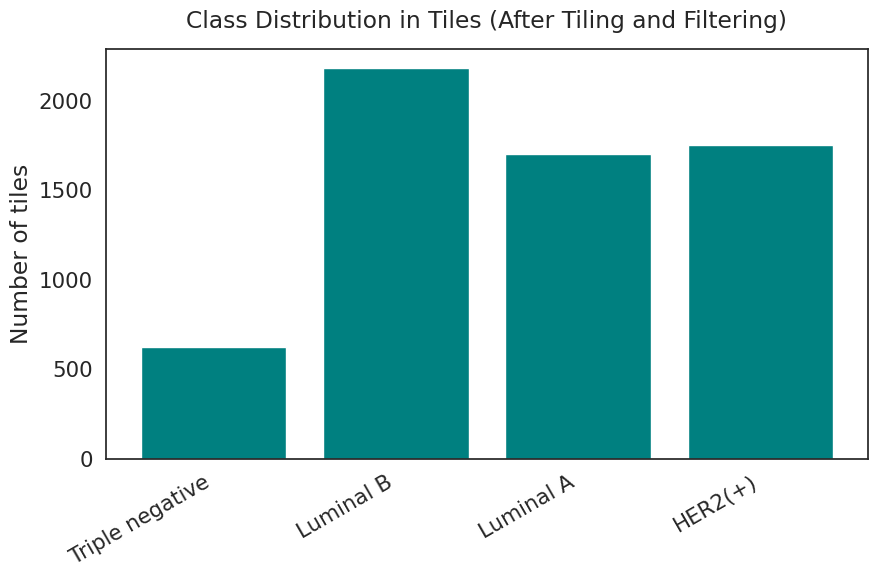

In [21]:
import matplotlib.pyplot as plt
from collections import Counter
import random
import math

# Assuming 'tiled_full_dataset' has been successfully created in the previous step
print(f"Total Number of Extracted Tiles: {len(tiled_full_dataset)}")


# ---------------------------------------------------------
# 📊 TILE'S LABELS DISTRIBUTION
# ---------------------------------------------------------

# Extract the encoded labels from the generated samples
labels_encoded = [label for _, label in tiled_full_dataset.samples]
label_counts = Counter(labels_encoded)

# Create a mapping from encoded index back to the string class name for readability
# (Assuming 'class_names' list is defined from the initial LabelEncoder step)
class_label_map = {i: name for i, name in enumerate(class_names)}

print("\n Tile's Label Distribution")
# Print using the human-readable class names
for cls_idx, count in label_counts.items():
    print(f"{class_label_map[cls_idx]}: {count} tiles")

# Bar plot
plt.figure(figsize=(9, 6))
# Use string labels for better visualization
plot_labels = [class_label_map[cls_idx] for cls_idx in label_counts.keys()]
plt.bar(plot_labels, label_counts.values(), color="teal")
plt.title("Class Distribution in Tiles (After Tiling and Filtering)", pad=15)
plt.ylabel("Number of tiles")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()




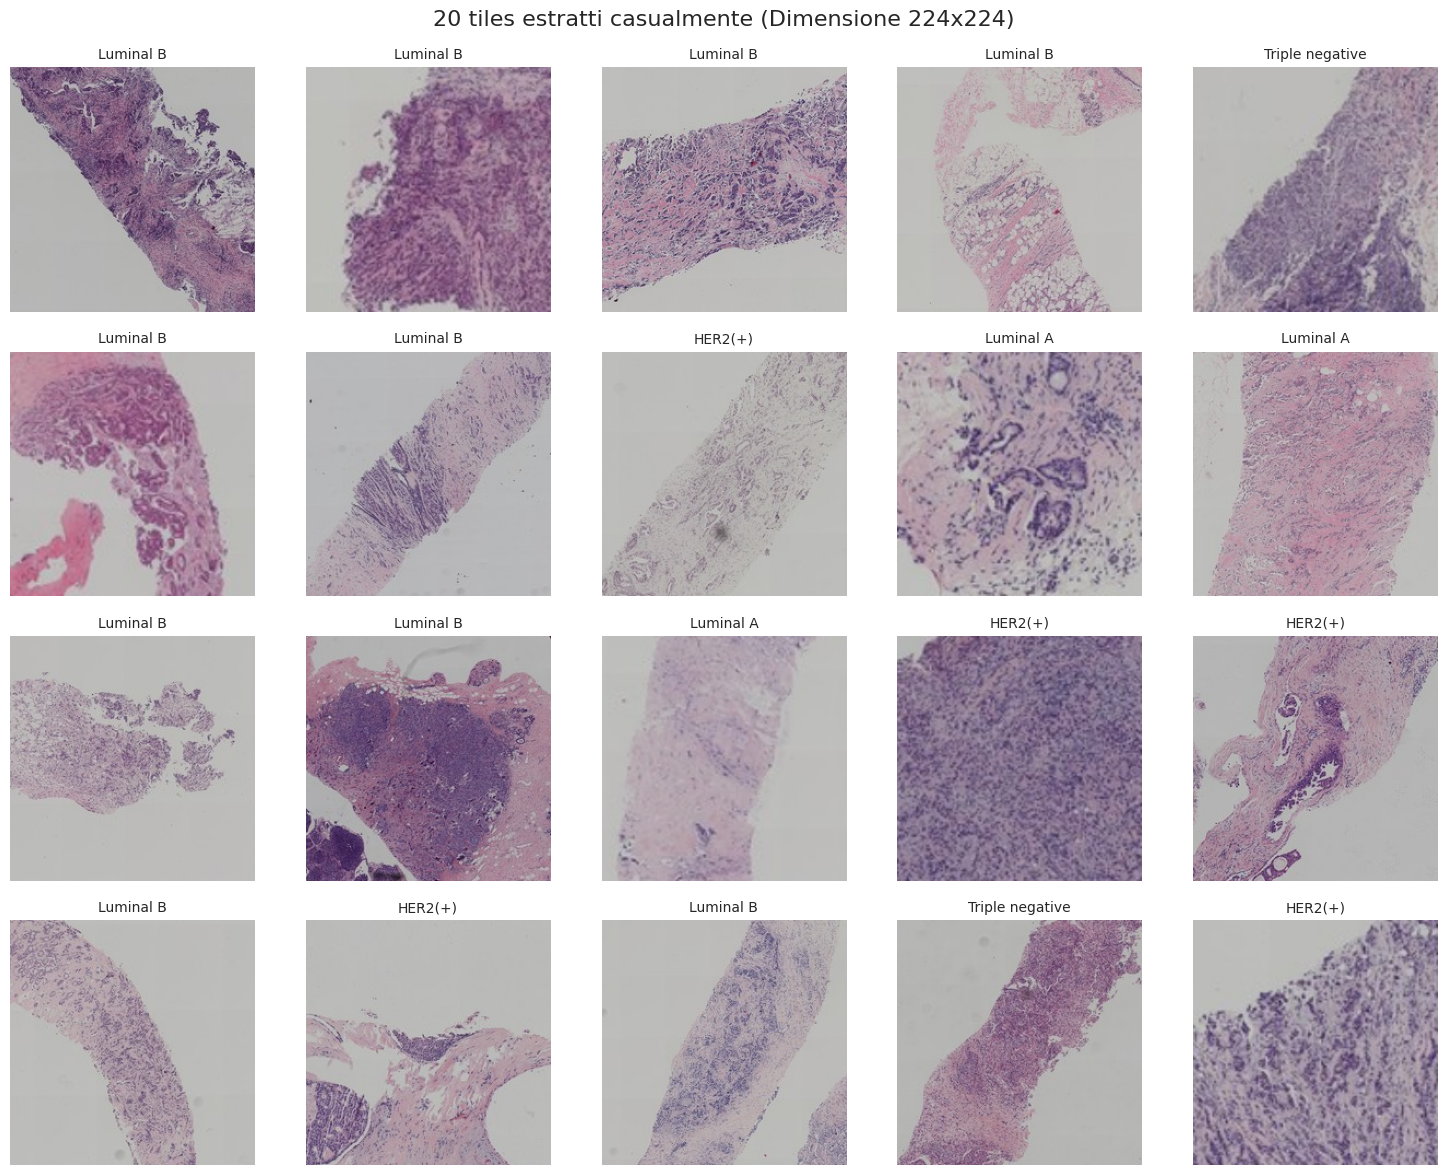

In [49]:
# ---------------------------------------------------------
# 🖼️ STAMPA DI ALCUNE IMMAGINI DEL DATASET (Corrected)
# ---------------------------------------------------------

def show_random_tiles(dataset, n=20):
    """Visualizza n tiles estratti casualmente dal dataset."""
    idxs = random.sample(range(len(dataset)), n)

    cols = int(math.ceil(math.sqrt(n)))
    rows = int(math.ceil(n / cols))

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, idx in enumerate(idxs):
        # When you access the dataset here, you get the PIL image
        img_pil, label_encoded = dataset[idx]

        plt.subplot(rows, cols, i + 1)

        # Display the PIL Image directly.
        # Matplotlib handles PIL images without needing C H W -> H W C permutation.
        plt.imshow(img_pil)

        # Display the human-readable class name
        class_name = class_label_map.get(label_encoded, "Unknown")
        plt.title(class_name, fontsize=10)
        plt.axis("off")

    plt.suptitle(f"{n} tiles estratti casualmente (Dimensione {dataset.tile_size}x{dataset.tile_size})", fontsize=16)
    plt.tight_layout()
    plt.show()

# Re-run the function
show_random_tiles(tiled_full_dataset, n=20)

##  **Data Splitting in Training and Validation Set**

In [24]:
## custom 90-degree rotation function ##
class Random90Rotation(object):
    """Rotates image randomly by 0, 90, 180, or 270 degrees."""
    def __init__(self, p=0.5):
        self.degrees = [0, 90, 180, 270]
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            angle = random.choice(self.degrees)
            return img.rotate(angle, resample=Image.BICUBIC)
        return img

In [26]:
##  **Data Splitting in Training and Validation Set (CORRETTO, NO LEAKAGE, STRATIFIED)**

from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. Slide-level dataframe (serve per stratificazione)
# ---------------------------------------------------------
slide_labels = labels_df[["sample_index", "label"]].drop_duplicates()

# ---------------------------------------------------------
# 2. Stratified train/val split per SLIDE
# ---------------------------------------------------------
train_ids, val_ids = train_test_split(
    slide_labels["sample_index"],
    test_size=0.10,
    random_state=SEED,
    stratify=slide_labels["label"]  # stratificazione per classe
)

print("\n--- Slide-level Split (NO LEAKAGE) ---")
print(f"Training slides:   {len(train_ids)}")
print(f"Validation slides: {len(val_ids)}")

# ---------------------------------------------------------
# 3. Filtra il labels_df per ottenere i due insiemi
# ---------------------------------------------------------
train_labels_df = labels_df[labels_df["sample_index"].isin(train_ids)]
val_labels_df   = labels_df[labels_df["sample_index"].isin(val_ids)]

print(f"Training slide entries:   {len(train_labels_df)}")
print(f"Validation slide entries: {len(val_labels_df)}")

# ---------------------------------------------------------
# 4. Definisci i Transform corretti (senza Macenko)
# ---------------------------------------------------------

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    Random90Rotation(p=0.75),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(degrees=20, translate=(0.05,0.05), scale=(0.95,1.05)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

print("\n✅ Transformation pipelines defined.")

# ---------------------------------------------------------
# 5. Crea i dataset TRAIN e VAL (Macenko è GIÀ applicato nel dataset)
# ---------------------------------------------------------

train_dataset = HistologyMaskedTiles(
    img_dir=TRAIN_IMG_DIR,
    labels_df=train_labels_df,
    le=le,
    tile_size=224,
    transform=train_transforms,
    min_mask_ratio=0.01,
)

val_dataset = HistologyMaskedTiles(
    img_dir=TRAIN_IMG_DIR,
    labels_df=val_labels_df,
    le=le,
    tile_size=224,
    transform=val_transforms,
    min_mask_ratio=0.01,
)

print(f"Total TRAIN tiles: {len(train_dataset)}")
print(f"Total VAL   tiles: {len(val_dataset)}")

# ---------------------------------------------------------
# 6. DataLoader Creation
# ---------------------------------------------------------

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print(f"\n✅ DataLoaders created with BATCH_SIZE={BATCH_SIZE}.")
print(f"Training batches:   {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")


--- Slide-level Split (NO LEAKAGE) ---
Training slides:   522
Validation slides: 59
Training slide entries:   522
Validation slide entries: 59

✅ Transformation pipelines defined.
Total tiles extracted: 5657
Total tiles extracted: 612
Total TRAIN tiles: 5657
Total VAL   tiles: 612

✅ DataLoaders created with BATCH_SIZE=32.
Training batches:   177
Validation batches: 20


##  **Weighted Loss on Tiles Imbalance**



In [27]:
import torch
import numpy as np

# Count labels inside the TRAIN dataset (tile-level)
train_labels = [label for (_, label) in train_dataset.samples]

# Compute class counts
class_counts = np.bincount(train_labels, minlength=num_classes)

# Inverse frequency weighting
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize to sum=1

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class counts:", class_counts)
print("Class weights:", class_weights_tensor)


Class counts: [1589 1536 1962  570]
Class weights: tensor([0.1776, 0.1837, 0.1438, 0.4950], device='cuda:0')


##  **DON'T RUN IT !!!!!!! Weighted Loss on Original Imbalance**



In [ ]:
# --- 1. Get Class Counts (from the original labels_df) ---
# Ensure the order matches the integer encoding: 0, 1, 2, 3
class_counts = labels_df['label_encoded'].value_counts().sort_index().values
num_samples = len(labels_df)

# --- 2. Calculate Inverse Class Frequencies ---
# Formula: weight_i = (Total Samples) / (Class i Count)
class_weights = num_samples / class_counts

# --- 3. Normalize Weights (Optional but recommended for stability) ---
# Normalize to make the average weight 1.
class_weights = class_weights / class_weights.sum() * num_classes

# --- 4. Convert to PyTorch Tensor ---
class_weights_tensor = torch.from_numpy(class_weights).float().to(device)

print("\n--- Weighted Loss Configuration ---")
print(f"Raw Counts (0, 1, 2, 3): {class_counts}")
print(f"Calculated Weights: {class_weights_tensor.cpu().numpy().round(3)}")


--- Weighted Loss Configuration ---
Raw Counts (0, 1, 2, 3): [160 175 220  77]
Calculated Weights: [0.848 0.775 0.616 1.761]


##  🧮 **Network Parameters**

In [28]:
# Training parameters
LEARNING_RATE = 5e-4
EPOCHS = 200
PATIENCE = 20

# Regularization
DROPOUT_RATE = 0.4

# Set up loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1) #Weighted Loss
criterion_val = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1) #Weighted Loss
#criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)

Epochs: 200
Batch Size: 32
Learning Rate: 0.0005
Dropout Rate: 0.4
Patience: 20


##  🧠 **Training Functions**

In [29]:
from sklearn.metrics import accuracy_score, f1_score # Ensure f1_score is imported

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        # Automatic Mixed Precision (AMP) block for efficient CUDA utilization
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

        # Scale the loss, backpropagate, and update
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_acc

In [30]:
def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch, calculating loss, accuracy, and F1-Score."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # AMP block
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(y_true, y_pred)

    # Competition Metric: Calculate the Macro F1-Score
    epoch_f1 = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, epoch_accuracy, epoch_f1

In [31]:
def fit(model, train_loader, val_loader, epochs, criterion, criterion_val, optimizer, scaler, device,
        # Add new parameters
        unfreeze_epoch=0, fine_tune_lr=None,
        patience=PATIENCE, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):
    """
    Train the neural network model.
    Evaluation Metric is set to 'val_f1' by default for the competition.
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': [] # Added F1-Score tracking
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")
    print(f"Backbone will be unfrozen and LR set to {fine_tune_lr} at Epoch {unfreeze_epoch}.")

    for epoch in range(1, epochs + 1):
        # --- Adaptive Learning Rate & Unfreezing Logic ---
        if epoch == unfreeze_epoch and unfreeze_epoch > 0:
            print(f"\n📢 Epoch {epoch}: Unfreezing the backbone and initiating fine-tuning...")

            # 1. Unfreeze the entire model (all parameters)
            for param in model.parameters():
                param.requires_grad = True

            # 2. Re-create the optimizer with the new, lower learning rate
            # This is the "Adaptive Learning Rate" step
            optimizer = torch.optim.Adam(
                model.parameters(), # Now optimizing ALL parameters
                lr=fine_tune_lr
            )
            print(f"Optimizer reset with Learning Rate: {fine_tune_lr}")

        # --- Training Step ---
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        # --- Validation Step ---
        # Capture the new F1-Score return value
        val_loss, val_acc, val_f1 = validate_one_epoch(
            model, val_loader, criterion_val, device
        )

        # --- Update History ---
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)
        training_history['val_f1'].append(val_f1) # Record F1-Score

        # --- TensorBoard Logging ---
        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Training', train_acc, epoch)
            writer.add_scalar('Accuracy/Validation', val_acc, epoch)
            writer.add_scalar('F1-Score/Validation', val_f1, epoch) # Log F1-Score

        # --- Console Output ---
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                # Add a marker for the fine-tuning phase
                phase = "Head Frozen" if epoch < unfreeze_epoch else "Fine-Tuning"
                print(f"Epoch {epoch:3d}/{epochs} ({phase}) | "
                      f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                      f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        # --- Early Stopping Logic ---
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                # Save the model state dict
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs (no improvement in {evaluation_metric} for {patience} epochs).")
                    break

    # --- Final Actions ---
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        # Save the final model if no early stopping was used
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

## 🛠️ **Transfer Learning (with integrated Fine Tuning) resnet18**

In [32]:
# --- Configuration (Update for ResNet18) ---
MODEL_BACKBONE = 'resnet18'
# DROPOUT_RATE, LEARNING_RATE, EPOCHS, PATIENCE are assumed to be defined globally.
# BATCH_SIZE is assumed to be defined globally (e.g., BATCH_SIZE = 32).
FREEZE_BACKBONE = True # Start with freezing, then fine-tune later
UNFREEZE_EPOCH = 20
FINE_TUNE_LEARNING_RATE = 1e-5 # Much smaller LR for the backbone
# num_classes is assumed to be defined globally (e.g., num_classes = 4).

# --- Define Input Shape for Summary ---
# ResNet models typically expect 224x224 input, but summary can work with your 256x256 tiles.
# Assuming 3 color channels (RGB)
input_shape = (3, 224, 224)

In [33]:
class ResNet18TransferLearning(nn.Module):
    """
    ResNet18 with pretrained weights for transfer learning.

    IMPORTANT: This model expects ImageNet-normalized inputs!
    Images should be normalized with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
    """

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # ResNet18 backbone with ImageNet pretrained weights
        self.backbone = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        )

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False


        # Replace the final fully connected layer (always trainable)
        # ResNet models use 'fc' for the classifier head
        in_features = self.backbone.fc.in_features

        # Create a new, custom classifier head
        # Adding an extra layer and Dropout is good practice for regularization
        self.backbone.fc = nn.Sequential(
             nn.Linear(in_features, in_features // 2),  # Custom intermediate layer
             nn.ReLU(),
             nn.Dropout(dropout_rate),
             nn.Linear(in_features // 2, num_classes)
        )

        # self.backbone.fc = nn.Sequential(
        #     nn.Linear(in_features, 512),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(512),
        #     nn.Dropout(0.25),

        #     nn.Linear(512, 128),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(128),
        #     nn.Dropout(0.15),

        #     nn.Linear(128, num_classes)
        # )

        # self.backbone.fc = nn.Sequential(
        #     nn.Dropout(0.2),
        #     nn.Linear(in_features, num_classes)
        # )



    def forward(self, x):
        return self.backbone(x)

In [34]:
# Create transfer learning model
# NOTE: Ensure num_classes is defined (it should be 4 from your earlier code)
tl_model = ResNet18TransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=FREEZE_BACKBONE,
).to(device)

print(f"Model created: {MODEL_BACKBONE} (Backbone frozen: {FREEZE_BACKBONE})")

# Display model summary
summary(tl_model, input_size=input_shape)
# The torchview code is commented out as it relies on an external library and can be slow:
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


Model created: resnet18 (Backbone frozen: True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]        

In [35]:
# --- Setup Training ---
# Assumed to be defined globally: train_dataloader, val_dataloader, criterion, BATCH_SIZE, LEARNING_RATE, EPOCHS, PATIENCE, fit function.

# Print the defined parameters
print("\n--- Training Parameters ---")
print("Model Backbone:", MODEL_BACKBONE)
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience (Early Stopping):", PATIENCE)
print("Loss Function:", criterion.__class__.__name__)


experiment_name = f"tl_{MODEL_BACKBONE}_{'frozen' if FREEZE_BACKBONE else 'finetune'}"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)


# Optimizer: Only optimize trainable parameters (the new classification head)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=LEARNING_RATE
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\nStarting training for experiment: {experiment_name}")




--- Training Parameters ---
Model Backbone: resnet18
Epochs: 200
Batch Size: 32
Learning Rate: 0.0005
Dropout Rate: 0.4
Patience (Early Stopping): 20
Loss Function: CrossEntropyLoss

Starting training for experiment: tl_resnet18_frozen


In [36]:

# %%time (Use this magic command in your notebook cell)
# Train with transfer learning
# NOTE: This assumes your 'fit' function is defined correctly in a preceding cell.
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_dataloader, # Use the global loader defined earlier
    val_loader=val_dataloader,      # Use the global loader defined earlier
    epochs=EPOCHS,
    criterion=criterion,
    criterion_val=criterion_val,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1', # Prioritize the competition metric
    # NEW ARGUMENTS FOR ADAPTIVE LEARNING:
    unfreeze_epoch=UNFREEZE_EPOCH,
    fine_tune_lr=FINE_TUNE_LEARNING_RATE
)

Training 200 epochs...
Backbone will be unfrozen and LR set to 1e-05 at Epoch 20.
Epoch   1/200 (Head Frozen) | Train: Loss=1.4159, Acc=0.2844 | Val: Loss=1.3625, Acc=0.3611, F1=0.3181
Epoch   5/200 (Head Frozen) | Train: Loss=1.3589, Acc=0.3350 | Val: Loss=1.3641, Acc=0.4314, F1=0.3511
Epoch  10/200 (Head Frozen) | Train: Loss=1.3475, Acc=0.3576 | Val: Loss=1.3626, Acc=0.3807, F1=0.3501
Epoch  15/200 (Head Frozen) | Train: Loss=1.3316, Acc=0.3748 | Val: Loss=1.3587, Acc=0.4150, F1=0.3775

📢 Epoch 20: Unfreezing the backbone and initiating fine-tuning...
Optimizer reset with Learning Rate: 1e-05
Epoch  20/200 (Fine-Tuning) | Train: Loss=1.3125, Acc=0.4009 | Val: Loss=1.3584, Acc=0.4085, F1=0.3827
Epoch  25/200 (Fine-Tuning) | Train: Loss=1.2319, Acc=0.4644 | Val: Loss=1.3659, Acc=0.4216, F1=0.4014
Epoch  30/200 (Fine-Tuning) | Train: Loss=1.1786, Acc=0.5038 | Val: Loss=1.4191, Acc=0.4036, F1=0.3782
Epoch  35/200 (Fine-Tuning) | Train: Loss=1.1210, Acc=0.5506 | Val: Loss=1.4007, Acc=0.4

## 🛠️ **Transfer Learning (with integrated fine tuning) EfficientNet**

In [ ]:
MODEL_BACKBONE = 'efficientnet_b2'
FREEZE_BACKBONE = True
UNFREEZE_EPOCH = 20
FINE_TUNE_LEARNING_RATE = 1e-6
input_shape = (3, 224, 224)  # EfficientNet supports 224 or up to 256; 256 is fine


In [ ]:
class EfficientNetTransferLearning(nn.Module):
    """
    EfficientNet-B0 or B2 with transfer learning.
    """
    def __init__(self, model_name="efficientnet_b2", num_classes=4,
                 dropout_rate=0.45, freeze_backbone=True):
        super().__init__()

        # 1. Load pretrained EfficientNet model
        if model_name == "efficientnet_b0":
            weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
            self.backbone = torchvision.models.efficientnet_b0(weights=weights)
        elif model_name == "efficientnet_b2":
            weights = torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1
            self.backbone = torchvision.models.efficientnet_b2(weights=weights)
        else:
            raise ValueError("model_name must be 'efficientnet_b0' or 'efficientnet_b2'.")

        # 2. Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # 3. Replace the classifier head
        # EfficientNet uses "classifier" = Dropout + Linear
        in_features = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


In [ ]:
tl_model = EfficientNetTransferLearning(
    model_name=MODEL_BACKBONE,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=FREEZE_BACKBONE
).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 131MB/s]


In [ ]:
# --- Setup Training ---
# Assumed to be defined globally: train_dataloader, val_dataloader, criterion, BATCH_SIZE, LEARNING_RATE, EPOCHS, PATIENCE, fit function.

# Print the defined parameters
print("\n--- Training Parameters ---")
print("Model Backbone:", MODEL_BACKBONE)
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience (Early Stopping):", PATIENCE)
print("Loss Function:", criterion.__class__.__name__)


experiment_name = f"tl_{MODEL_BACKBONE}_{'frozen' if FREEZE_BACKBONE else 'finetune'}"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\nStarting training for experiment: {experiment_name}")

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=LEARNING_RATE
)

summary(tl_model, input_size=input_shape)


--- Training Parameters ---
Model Backbone: efficientnet_b2
Epochs: 200
Batch Size: 32
Learning Rate: 0.005
Dropout Rate: 0.45
Patience (Early Stopping): 20
Loss Function: CrossEntropyLoss

Starting training for experiment: tl_efficientnet_b2_frozen
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1,

In [ ]:
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=EPOCHS,
    criterion=criterion,
    criterion_val=criterion_val,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1',
    unfreeze_epoch=UNFREEZE_EPOCH,
    fine_tune_lr=FINE_TUNE_LEARNING_RATE
)



Training 200 epochs...
Backbone will be unfrozen and LR set to 1e-06 at Epoch 20.
Epoch   1/200 (Head Frozen) | Train: Loss=1.5009, Acc=0.3063 | Val: Loss=1.4083, Acc=0.3485, F1=0.3170
Epoch   5/200 (Head Frozen) | Train: Loss=1.5276, Acc=0.3504 | Val: Loss=1.5804, Acc=0.3068, F1=0.2879
Epoch  10/200 (Head Frozen) | Train: Loss=1.5828, Acc=0.3410 | Val: Loss=1.5315, Acc=0.3182, F1=0.3005
Epoch  15/200 (Head Frozen) | Train: Loss=1.5780, Acc=0.3468 | Val: Loss=1.4759, Acc=0.3371, F1=0.3125

📢 Epoch 20: Unfreezing the backbone and initiating fine-tuning...
Optimizer reset with Learning Rate: 1e-06
Epoch  20/200 (Fine-Tuning) | Train: Loss=1.5716, Acc=0.3189 | Val: Loss=1.5055, Acc=0.3371, F1=0.3194
Epoch  25/200 (Fine-Tuning) | Train: Loss=1.5225, Acc=0.3252 | Val: Loss=1.4501, Acc=0.3523, F1=0.3248
Early stopping triggered after 27 epochs (no improvement in val_f1 for 20 epochs).
Best model restored from epoch 7 with val_f1 0.3602


## **MULTISCALE Inference**

In [42]:
from torch.utils.data import Dataset
import torch
import os
from torchvision import transforms
from collections import defaultdict

# =========================================================
#  TEST DATASET (MULTISCALE, CENTROID-BASED)
# =========================================================

class HistologyMaskedTilesTest(Dataset):
    """
    Test dataset for MULTISCALE inference.

    Each sample corresponds to ONE tumor centroid and returns:
    - multiscale_tensor: (K, 3, 224, 224)
    - slide_name
    """

    def __init__(self, img_dir, tile_size=224, min_mask_ratio=0.1, transform=None):
        self.img_dir = img_dir
        self.tile_size = tile_size
        self.min_mask_ratio = min_mask_ratio
        self.transform = transform

        self.zoom_factors = (0.58, 1.0)  # zoom-in, base, zoom-out
        self.K = len(self.zoom_factors)

        self.sample_names = sorted([
            f for f in os.listdir(img_dir) if f.startswith("img_")
        ])

        self.samples = self._generate_tiles()

    # -----------------------------------------------------

    def _generate_tiles(self):
        """
        Returns a list of:
        (list_of_K_PIL_tiles, slide_name)
        """
        all_samples = []

        for img_name in self.sample_names:

            img_path  = os.path.join(self.img_dir, img_name)
            mask_path = img_path.replace("img_", "mask_")

            if not os.path.exists(mask_path):
                print(f"[WARNING] mask not found for {img_name}, skipping.")
                continue

            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            # MULTISCALE CENTROID EXTRACTION (same as training)
            tiles = extract_multiscale_tiles_from_centroids(
                img,
                mask,
                tile_size=self.tile_size,
                min_mask_ratio=self.min_mask_ratio,
                zoom_factors=self.zoom_factors
            )

            if not tiles:
                print(f"[ERROR] no tiles for {img_name}, skipping.")
                continue

            # group tiles by centroid (K tiles per centroid)
            for i in range(0, len(tiles), self.K):
                multiscale_tiles = tiles[i:i+self.K]
                if len(multiscale_tiles) == self.K:
                    all_samples.append((multiscale_tiles, img_name))

        print(f"[TEST] Total multiscale samples: {len(all_samples)}")
        return all_samples

    # -----------------------------------------------------

    def __getitem__(self, idx):
        multiscale_tiles, slide_name = self.samples[idx]

        if self.transform is not None:
            multiscale_tensor = torch.stack([
                self.transform(t[0]) for t in multiscale_tiles
            ])  # (K, 3, 224, 224)
        else:
            multiscale_tensor = torch.stack([
                transforms.ToTensor()(t) for t in multiscale_tiles
            ])

        return multiscale_tensor, slide_name

    # -----------------------------------------------------

    def __len__(self):
        return len(self.samples)


In [43]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [44]:
test_dataset = HistologyMaskedTilesTest(
    img_dir=test_img_dir,
    tile_size=224,
    min_mask_ratio=0.01,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

[TEST] Total multiscale samples: 2461


In [45]:
import torch
from collections import defaultdict

def infer(model, loader, device):
    model.eval()
    slide_logits = defaultdict(list)

    with torch.no_grad():
        for multiscale_tiles, slide_names in loader:
            # multiscale_tiles: (B, K, 3, 224, 224)
            B, K, C, H, W = multiscale_tiles.shape

            multiscale_tiles = multiscale_tiles.view(B*K, C, H, W).to(device)
            logits = model(multiscale_tiles)  # (B*K, num_classes)

            # aggregate over scales (zoom-in / base / zoom-out)
            logits = logits.view(B, K, -1).mean(dim=1)  # (B, num_classes)

            for logit, name in zip(logits, slide_names):
                slide_logits[name].append(logit.cpu())

    # aggregate over centroids → slide-level prediction
    predictions = {}
    for slide, logit_list in slide_logits.items():
        slide_logit = torch.stack(logit_list).mean(dim=0)
        predictions[slide] = slide_logit.argmax().item()

    return predictions

In [46]:
preds = infer(tl_model, test_loader, device)

# 4. Convert numeric predictions to text labels
int_to_label = {i: label for i, label in enumerate(le.classes_)}
preds_text = {
    sample: int_to_label[pred]
    for sample, pred in preds.items()
}

# 5. Build final dataframe
df = pd.DataFrame({
    "sample_index": list(preds_text.keys()),
    "label": list(preds_text.values())
})


df.to_csv("first_multiscale_preprocess.csv", index=False)
print("Saved first_multiscale_preprocess.csv")

from google.colab import files
files.download("first_multiscale_preprocess.csv")


Saved first_multiscale_preprocess.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# Estrai gli indici numerici dalla forma "img_XXXX.png"
predicted = set(
    int(name.replace("img_", "").replace(".png", ""))
    for name in preds.keys()
)

expected = set(range(476))

missing = sorted(list(expected - predicted))

print("Numero label mancanti:", len(missing))
print("Label mancanti:", missing[:50])  # Stampa solo le prime 50

Numero label mancanti: 0
Label mancanti: []


## **Inference**

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os
from PIL import Image
from torchvision import transforms


class HistologyMaskedTilesTest(Dataset):
    """
    Test dataset for inference / visualization.

    - Uses centroid-based tile extraction (same as training)
    - Applies mask cleaning
    - Applies Macenko normalization !! HERE COMMENTED
    - Applies post-Macenko mask multiplication
    - Returns (tile_tensor, img_name)
    """
    #
    def __init__(self, img_dir, tile_size=224, min_mask_ratio=0.1, transform=None):
        self.img_dir = img_dir
        self.tile_size = tile_size
        self.min_mask_ratio = min_mask_ratio
        self.transform = transform

        self.macenko = MacenkoTransform() #!!COMMENTED

        # list files like img_XXXX.png
        self.sample_names = sorted([
            f for f in os.listdir(img_dir) if f.startswith("img_")
        ])

        self.tiles = self._generate_tiles()


    # ---------------------------------------------------------
    # MAIN EXTRACTION LOGIC
    # ---------------------------------------------------------
    def _generate_tiles(self):
        all_tiles = []

        for img_name in self.sample_names:

            img_path  = os.path.join(self.img_dir, img_name)
            mask_path = img_path.replace("img_", "mask_")

            if not os.path.exists(mask_path):
                print(f"[WARNING] mask not found for {img_name}, skipping.")
                continue

            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            # 1️⃣ CENTROID-BASED TILES (high quality)
            tiles = extract_tiles_from_centroids(
                img, mask,
                tile_size=self.tile_size,
                min_mask_ratio=self.min_mask_ratio
            )

            # FALLBACK
            if not tiles:
                print(f"[FALLBACK] centroid failed for {img_name}, using sliding window")
                tiles = fallback_sliding_window(
                    img, mask,
                    tile_size=self.tile_size,
                    min_mask_ratio=self.min_mask_ratio * 0.2
                )

                if not tiles:
                    print(f"[ERROR] no tile possible for {img_name}, skipping")
                    continue

            # aggregate
            for tile_pil, tile_mask in tiles:  # ignore mask here
                t_norm = tile_pil # self.macenko(tile_pil) !! COMMENTED MACENKO
                # store tile and image name
                all_tiles.append((t_norm, img_name))

        print(f"[TEST] Total test tiles generated: {len(all_tiles)}")
        return all_tiles


    # ---------------------------------------------------------
    # DATASET API
    # ---------------------------------------------------------
    def __getitem__(self, idx):
        tile_pil, sample_name = self.tiles[idx]

        if self.transform is not None:
            tile_tensor = self.transform(tile_pil)
        else:
            tile_tensor = transforms.ToTensor()(tile_pil)

        return tile_tensor, sample_name


    def __len__(self):
        return len(self.tiles)

In [ ]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [ ]:
test_dataset = HistologyMaskedTilesTest(
    img_dir=test_img_dir,
    tile_size=224,
    min_mask_ratio=0.01,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

[FALLBACK] centroid failed for img_0017.png, using sliding window
[FALLBACK] centroid failed for img_0034.png, using sliding window
[ERROR] no tile possible for img_0034.png, skipping
[FALLBACK] centroid failed for img_0050.png, using sliding window
[FALLBACK] centroid failed for img_0080.png, using sliding window
[FALLBACK] centroid failed for img_0086.png, using sliding window
[FALLBACK] centroid failed for img_0104.png, using sliding window
[FALLBACK] centroid failed for img_0107.png, using sliding window
[FALLBACK] centroid failed for img_0140.png, using sliding window
[FALLBACK] centroid failed for img_0148.png, using sliding window
[FALLBACK] centroid failed for img_0173.png, using sliding window
[FALLBACK] centroid failed for img_0177.png, using sliding window
[FALLBACK] centroid failed for img_0197.png, using sliding window
[FALLBACK] centroid failed for img_0324.png, using sliding window
[FALLBACK] centroid failed for img_0358.png, using sliding window
[ERROR] no tile possible

In [ ]:
print("Unique slide names in loader:", len(set([n for _, batch_names in test_loader for n in batch_names])))
print(len(os.listdir(test_img_dir)))


Unique slide names in loader: 475
954


In [ ]:
import torch.nn.functional as F
from collections import defaultdict

def infer(model, loader, device):
    model.eval()

    # dictionary: sample_name → lista logits
    slide_logits = defaultdict(list)

    with torch.no_grad():
        for images, names in loader:
            images = images.to(device)
            logits = model(images)  # shape (batch, num_classes)

            for logit, name in zip(logits, names):
                slide_logits[name].append(logit.cpu())

    # final predictions
    predictions = {}
    for slide, logit_list in slide_logits.items():
        mean_logit = torch.stack(logit_list).mean(dim=0)
        pred = mean_logit.argmax().item()
        predictions[slide] = pred

    return predictions

In [ ]:
preds = infer(tl_model, test_loader, device)

# 4. Convert numeric predictions to text labels
int_to_label = {i: label for i, label in enumerate(le.classes_)}
preds_text = {
    sample: int_to_label[pred]
    for sample, pred in preds.items()
}

# 5. Build final dataframe
df = pd.DataFrame({
    "sample_index": list(preds_text.keys()),
    "label": list(preds_text.values())
})


df.to_csv("new_preprocess.csv", index=False)
print("Saved new_preprocess.csv")

from google.colab import files
files.download("new_preprocess.csv")


Saved new_preprocess.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Estrai gli indici numerici dalla forma "img_XXXX.png"
predicted = set(
    int(name.replace("img_", "").replace(".png", ""))
    for name in preds.keys()
)

expected = set(range(476))

missing = sorted(list(expected - predicted))

print("Numero label mancanti:", len(missing))
print("Label mancanti:", missing[:50])  # Stampa solo le prime 50

Numero label mancanti: 2
Label mancanti: [34, 358]


## 🌅 **Grad-CAM**

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()

        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook: salva attivazioni forward
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Hook: salva gradienti backward
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class):
        """
        input_tensor: (1,3,H,W) già sul device corretto
        target_class: classe su cui calcolare Grad-CAM
        """

        device = input_tensor.device
        self.model.zero_grad()

        # Forward
        output = self.model(input_tensor)
        score = output[0, target_class]

        # Backward
        score.backward(retain_graph=True)

        # Move stored activations & gradients to GPU
        gradients = self.gradients[0].to(device)
        activations = self.activations[0].to(device)

        # GAP dei gradienti
        weights = gradients.mean(dim=(1, 2))

        # CAM iniziale
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=device)

        # Weighted sum
        for k, w in enumerate(weights):
            cam += w * activations[k]

        # ReLU
        cam = F.relu(cam)

        # Normalizzazione
        cam -= cam.min()
        cam /= cam.max() + 1e-12

        # Ritorna su CPU come numpy
        return cam.detach().cpu().numpy()

In [ ]:
def plot_gradcam_for_tile(
    tile_pil,
    tensor,
    model,
    gradcam,
    class_idx,
    title=None
):

    # CAM usando il tensore preprocessato
    cam = gradcam.generate(tensor, class_idx)
    cam = cv2.resize(cam, (tile_pil.size[0], tile_pil.size[1]))

    # Heatmap
    heatmap = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay
    tile_arr = np.array(tile_pil)
    overlay = (0.4 * heatmap + 0.6 * tile_arr).astype(np.uint8)

    # Plot
    plt.figure(figsize=(12,4))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1,3,1)
    plt.imshow(tile_arr)
    plt.title("Original Tile")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam, cmap="jet")
    plt.title("Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

    return cam, heatmap, overlay

In [ ]:
from collections import defaultdict

# ======================================================================
# Grad-CAM su TRAIN + VALIDATION
#
# • Grad-CAM on TRAIN helps verify that the model learns meaningful
#   morphological patterns rather than artifacts or spurious correlations
#   (useful for detecting overfitting or leakage).
#
# • Grad-CAM on VALIDATION shows how the model generalizes to unseen data,
#   providing a realistic and clinically interpretable view of the features
#   driving its decisions.
# ======================================================================


def gradcam_on_train_and_val(
    train_dataset,
    val_dataset,
    model,
    gradcam,
    num_samples=4
):

    datasets = {
        "train": (train_dataset, train_transforms),
        "validation": (val_dataset, val_transforms)
    }

    for set_name, (dataset, transform) in datasets.items():

        print(f"\n==============================")
        print(f"🔥 Grad-CAM on {set_name.upper()} dataset")
        print(f"==============================")

        # Raggruppa tile per classe
        class_to_indices = defaultdict(list)
        for idx in range(len(dataset.samples)):
            _, label = dataset.samples[idx]
            class_to_indices[label].append(idx)

        for cls, idxs in class_to_indices.items():

            chosen = random.sample(idxs, min(num_samples, len(idxs)))
            print(f"\n📌 {set_name.upper()} – Classe {cls}: {len(chosen)} tile")

            for tile_idx in chosen:

                tile_pil, true_label = dataset.samples[tile_idx]

                # --- Transform ---
                tensor = transform(tile_pil).unsqueeze(0).to(next(model.parameters()).device)

                # Predizione
                pred = torch.argmax(model(tensor)).item()

                # Titolo del plot
                title = f"{set_name.upper()} | True={true_label} | Pred={pred}"

                plot_gradcam_for_tile(
                    tile_pil=tile_pil,
                    tensor=tensor,
                    model=model,
                    gradcam=gradcam,
                    class_idx=pred,
                    title=title
                )


In [ ]:
# GRAD-CAM from the fine-tuned model trained

# Select the layer to put the grad-CAM, the last layers recognize the "overall pattern" better,
# Try also other layer to understand better the learning process (depends also on the unfreeze layers selected)
# The last layer has worst resolution, while the previous have better ones

target_layer = tl_model.backbone.layer4[-1].conv2
#target_layer = ft_model.backbone.layer3[-1].conv2
#target_layer = ft_model.backbone.layer2[-1].conv2

gradcam = GradCAM(tl_model, target_layer)
print(target_layer)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [ ]:
# PLOT the heatmap
gradcam_on_train_and_val(
    train_dataset,
    val_dataset,
    tl_model,
    gradcam,
    num_samples=4
)

## **------------------------------DIVISORIO---------------------------------**

##**EfficientNet**

In [ ]:
# Transfer Learning (frozen backbone)
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.35
PATIENCE = 20
EPOCHS = 100
LABEL_SMOOTHING = 0.05

# Fine Tuning (last 3 blocks unfrozen)
FT_LEARNING_RATE = 1e-4
FT_PATIENCE = 12
FT_EPOCHS = 80


In [ ]:
# Compute class frequencies
class_counts = labels_df["label_encoded"].value_counts().sort_index()

# Create weights inversely proportional to frequency
weights = 1.0 / class_counts.values
weights = weights / weights.sum() * len(class_counts)

class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class Weights:", class_weights)

# Weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=LABEL_SMOOTHING
)


Class Weights: tensor([0.8476, 0.7749, 0.6164, 1.7611], device='cuda:0')


In [ ]:
def fit(
        model,
        train_loader,
        val_loader,
        epochs,
        criterion,
        optimizer,
        scaler,
        device,
        patience=15,
        evaluation_metric="val_f1",
        mode="max",
        restore_best_weights=True,
        writer=None,
        verbose=1,
        experiment_name="model",
        scheduler=None
):
    """
    Unified training loop for EfficientNet/ResNet.
    Features:
    - mixed precision (AMP)
    - early stopping
    - saving best model on chosen metric
    - LR scheduler (optional)
    - TensorBoard logging
    - supports ReduceLROnPlateau OR CosineLR
    """

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "val_f1": []
    }

    best_metric = -float("inf") if mode == "max" else float("inf")
    patience_counter = 0
    best_epoch = 0
    best_path = f"models/{experiment_name}_model.pt"

    print(f"\n🔧 Starting training ({epochs} epochs) for experiment: {experiment_name}\n")

    for epoch in range(1, epochs + 1):

        # -----------------------------
        # 🔥 TRAIN ONE EPOCH
        # -----------------------------
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad(set_to_none=True)

            # AMP forward + backward
            with torch.autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * imgs.size(0)

            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total


        # -----------------------------
        # 🔍 VALIDATION
        # -----------------------------
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                with torch.autocast(device_type=device.type, dtype=torch.float16):
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * imgs.size(0)

                _, preds = outputs.max(1)
                val_correct += preds.eq(labels).sum().item()
                val_total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_f1 = f1_score(all_labels, all_preds, average="macro")

        # Store history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # -----------------------------
        # 📉 LR Scheduler
        # -----------------------------
        if scheduler is not None:
            # ReduceLROnPlateau expects val_loss
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # -----------------------------
        # 🖥️ TENSORBOARD
        # -----------------------------
        if writer is not None:
            writer.add_scalar("Loss/Train", train_loss, epoch)
            writer.add_scalar("Loss/Val", val_loss, epoch)
            writer.add_scalar("Acc/Train", train_acc, epoch)
            writer.add_scalar("Acc/Val", val_acc, epoch)
            writer.add_scalar("F1/Val", val_f1, epoch)
            writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

        # -----------------------------
        # 🖨️ LOGGING
        # -----------------------------
        if verbose and (epoch % verbose == 0 or epoch == 1):
            print(
                f"Epoch {epoch:3d}/{epochs} | LR={optimizer.param_groups[0]['lr']:.2e} | "
                f"Train: {train_loss:.4f}, Acc={train_acc:.4f} | "
                f"Val: {val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}"
            )

        # -----------------------------
        # 🛑 EARLY STOPPING
        # -----------------------------
        current_value = history[evaluation_metric][-1]
        improved = (current_value > best_metric) if mode == "max" else (current_value < best_metric)

        if improved:
            best_metric = current_value
            best_epoch = epoch
            patience_counter = 0
            torch.save(model.state_dict(), best_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⛔ Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
                break

    # -----------------------------
    # 🔙 RESTORE BEST WEIGHTS
    # -----------------------------
    if restore_best_weights:
        model.load_state_dict(torch.load(best_path))
        print(f"\n✅ Restored best model from epoch {best_epoch} "
              f"({evaluation_metric} = {best_metric:.4f})")

    if writer is not None:
        writer.close()

    return model, history


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights


class EfficientNetB2TransferLearning(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # Load pretrained EfficientNet-B2
        self.backbone = efficientnet_b2(
            weights=EfficientNet_B2_Weights.IMAGENET1K_V1
        )

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Extract classifier input size
        in_features = self.backbone.classifier[1].in_features

        # ⭐ Unified classification head (same for TL and FT)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )


    def forward(self, x):
        return self.backbone(x)


In [ ]:
###############################################
# 🔥 TRANSFER LEARNING – EfficientNet-B2
###############################################

MODEL_BACKBONE = "efficientnet_b2"
experiment_name = "tl_efficientnet_b2_frozen"

tl_model = EfficientNetB2TransferLearning(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=True
).to(device)

print(f"\nCreated model: {experiment_name}")

writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

# Optimizer → only classifier head
optimizer = torch.optim.RMSprop(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=LEARNING_RATE,
    alpha=0.9,
    momentum=0.9,
    weight_decay=1e-5
)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\n🚀 Starting transfer learning for: {experiment_name}")

tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1',
    scheduler=scheduler
)

print("\n✅ Transfer Learning completed.")
print("Model saved as:", f"models/{experiment_name}_model.pt")



Created model: tl_efficientnet_b2_frozen

🚀 Starting transfer learning for: tl_efficientnet_b2_frozen

🔧 Starting training (100 epochs) for experiment: tl_efficientnet_b2_frozen

Epoch   1/100 | LR=1.00e-04 | Train: 1.4034, Acc=0.3082 | Val: 1.4034, Acc=0.2960, F1=0.2591


In [ ]:
###############################################
# 🔥 FINE-TUNING – EfficientNet-B2
###############################################

experiment_name = "fine_tuning_efficientnet_b2"

# Create model with backbone UNFROZEN
ft_model = EfficientNetB2TransferLearning(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=False
).to(device)

# Load TL weights
tl_path = "models/tl_efficientnet_b2_frozen_model.pt"
print("Loading TL weights from:", tl_path)

ft_model.load_state_dict(torch.load(tl_path))
print("✅ Loaded TL weights successfully.")

# Step 1: Freeze everything
for _, param in ft_model.backbone.named_parameters():
    param.requires_grad = False

# Step 2: Unfreeze last 3 feature blocks
blocks_to_unfreeze = ["6", "7", "8"]

for name, param in ft_model.backbone.features.named_parameters():
    if any(name.startswith(b) for b in blocks_to_unfreeze):
        param.requires_grad = True

writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

# Optimizer → only unfreezed layers + classifier head
optimizer = torch.optim.RMSprop(
    filter(lambda p: p.requires_grad, ft_model.parameters()),
    lr=FT_LEARNING_RATE,
    alpha=0.9,
    momentum=0.9,
    weight_decay=1e-5
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

print(f"\n🚀 Starting fine-tuning for: {experiment_name}")

ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1',
    scheduler=scheduler
)

print("\n🎉 Fine Tuning Completed!")


Loading TL weights from: models/tl_efficientnet_b2_frozen_model.pt
✅ Loaded TL weights successfully.

🚀 Starting fine-tuning for: fine_tuning_efficientnet_b2

🔧 Starting training (40 epochs) for experiment: fine_tuning_efficientnet_b2

Epoch   1/40 | LR=1.00e-04 | Train: 1.4273, Acc=0.3438 | Val: 1.5179, Acc=0.2587, F1=0.2101
Epoch   5/40 | LR=1.00e-04 | Train: 1.2051, Acc=0.5194 | Val: 1.6783, Acc=0.2933, F1=0.2774
Epoch  10/40 | LR=3.00e-05 | Train: 0.8685, Acc=0.7301 | Val: 1.7817, Acc=0.3493, F1=0.3398
Epoch  15/40 | LR=2.70e-06 | Train: 0.7372, Acc=0.8168 | Val: 1.7862, Acc=0.3493, F1=0.3473
Epoch  20/40 | LR=1.00e-06 | Train: 0.7148, Acc=0.8390 | Val: 1.7792, Acc=0.3867, F1=0.3786
Epoch  25/40 | LR=1.00e-06 | Train: 0.7194, Acc=0.8319 | Val: 1.7669, Acc=0.3760, F1=0.3694

⛔ Early stopping at epoch 29 (no improvement for 18 epochs).

✅ Restored best model from epoch 11 (val_f1 = 0.3850)

🎉 Fine Tuning Completed!


## 🛠️ **Fine-Tuning**

In [ ]:
##MODEL_NAME_FROM_TRANSFER_LEARNING##
# MODEL_NAME_FROM_TRANSFER_LEARNING = tl_resnet18_frozen_model.pt

# --- Configuration (Reuse previous constants) ---
# Assuming these are defined:
# num_classes, DROPOUT_RATE, device
# EPOCHS, PATIENCE, criterion

FT_LEARNING_RATE = 1e-5 # Lower learning rate for fine-tuning

# --- Load Model (Unfrozen) ---
# Create the model instance with all layers potentially trainable
ft_model = ResNet18TransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=False # We handle freezing manually below
).to(device)

# Load the weights saved from the initial transfer learning (frozen backbone) stage
# NOTE: Exploiting model saving in 'fit' function torch.save(model.state_dict(), "models/transfer_learning_model.pt")
try:
    ft_model.load_state_dict(torch.load("models/tl_resnet18_frozen_model.pt"))
    print("✅ Successfully loaded weights from initial transfer learning stage.")
except FileNotFoundError:
    print("⚠️ WARNING: Could not find 'models/transfer_learning_model.pt'. Starting from scratch weights.")

# --- ResNet18 Layer Unfreezing Strategy ---

# ResNet18 layers are structured as: conv1, bn1, layer1, layer2, layer3, layer4, fc
# We want to primarily unfreeze layers starting from the end of the backbone.
# The 'backbone' layers are typically considered: layer4, layer3, layer2, etc.

# Layers in ResNet18 that contain feature extraction blocks:
resnet_feature_blocks = [
    ft_model.backbone.layer4,  # Last block (highest resolution features)
    ft_model.backbone.layer3,
    ft_model.backbone.layer2,
    ft_model.backbone.layer1,
]

# Set the number of feature *blocks* to unfreeze (e.g., the last 2 blocks: layer4 and layer3)
N_BLOCKS_TO_UNFREEZE = 3

# 1. First, freeze the entire backbone (excluding the 'fc' head, which is already handled)
for name, param in ft_model.named_parameters():
    # Only freeze parameters belonging to the backbone, not the final classifier ('fc')
    if 'fc' not in name:
        param.requires_grad = False

# 2. Unfreeze the last N blocks
unfrozen_blocks = resnet_feature_blocks[:N_BLOCKS_TO_UNFREEZE] # e.g., layer4 and layer3
unfrozen_names = []

for i, block in enumerate(unfrozen_blocks):
    for name, param in block.named_parameters():
        param.requires_grad = True
        unfrozen_names.append(f"backbone.layer{4-i}") # layer4, layer3, etc.

print(f"\nFine-tuning setup: Unfreezing the last {N_BLOCKS_TO_UNFREEZE} feature blocks.")

✅ Successfully loaded weights from initial transfer learning stage.

Fine-tuning setup: Unfreezing the last 3 feature blocks.


In [ ]:
# Count trainable parameters
total_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

# Display which layers are trainable
print("\nTrainable layers:")
for name, param in ft_model.named_parameters():
    if param.requires_grad:
        # Only print the layer/block name once
        if any(f"backbone.{block_name}" in name for block_name in ["layer4", "layer3", "layer2", "layer1", "fc"]):
            layer_name = name.split('.')[1]
        else:
            layer_name = name

        print(f"  {name} ({param.numel():,} parameters)")


Total parameters: 11,308,868
Trainable parameters: 11,151,364
Frozen parameters: 157,504

Trainable layers:
  backbone.layer2.0.conv1.weight (73,728 parameters)
  backbone.layer2.0.bn1.weight (128 parameters)
  backbone.layer2.0.bn1.bias (128 parameters)
  backbone.layer2.0.conv2.weight (147,456 parameters)
  backbone.layer2.0.bn2.weight (128 parameters)
  backbone.layer2.0.bn2.bias (128 parameters)
  backbone.layer2.0.downsample.0.weight (8,192 parameters)
  backbone.layer2.0.downsample.1.weight (128 parameters)
  backbone.layer2.0.downsample.1.bias (128 parameters)
  backbone.layer2.1.conv1.weight (147,456 parameters)
  backbone.layer2.1.bn1.weight (128 parameters)
  backbone.layer2.1.bn1.bias (128 parameters)
  backbone.layer2.1.conv2.weight (147,456 parameters)
  backbone.layer2.1.bn2.weight (128 parameters)
  backbone.layer2.1.bn2.bias (128 parameters)
  backbone.layer3.0.conv1.weight (294,912 parameters)
  backbone.layer3.0.bn1.weight (256 parameters)
  backbone.layer3.0.bn1.bia

In [ ]:
# --- Reuse Datasets and Create DataLoaders ---
# NOTE: Using the existing DataLoaders (train_dataloader, val_dataloader) created after the split.

train_ft_loader = train_dataloader
val_ft_loader = val_dataloader

# Setup training with lower learning rate for fine-tuning
experiment_name = f"fine_tuning_{MODEL_BACKBONE}_{N_BLOCKS_TO_UNFREEZE}blocks"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

print(f"\nStarting fine-tuning for experiment: {experiment_name}")

# Optimizer: Optimize all trainable parameters (frozen layers are ignored)
optimizer = torch.optim.Adam(
    ft_model.parameters(),
    lr=FT_LEARNING_RATE # Use the lower learning rate
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# %%time
# Fine-tune the model
ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name="fine_tuning",
    patience=PATIENCE,
    evaluation_metric='val_f1' # Continue prioritizing the competition metric
)

# --- Final Results ---
# Find the best F1-score from the history (assuming your 'fit' function logs this)
if ft_history and 'val_f1' in ft_history:
    final_val_f1 = round(max(ft_history['val_f1']) * 100, 2)
    print(f'\nFinal validation F1-Score: {final_val_f1}%')
else:
     print("\nTraining complete. Review history for best metrics.")


Starting fine-tuning for experiment: fine_tuning_resnet18_3blocks
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.0854, Acc=0.5283 | Val: Loss=1.3512, Acc=0.4735, F1=0.3556
Epoch   5/200 | Train: Loss=0.8603, Acc=0.6391 | Val: Loss=1.3855, Acc=0.4471, F1=0.3610
Epoch  10/200 | Train: Loss=0.7001, Acc=0.7176 | Val: Loss=1.8096, Acc=0.3735, F1=0.3140
Epoch  15/200 | Train: Loss=0.5202, Acc=0.7925 | Val: Loss=2.0281, Acc=0.4235, F1=0.3458
Epoch  20/200 | Train: Loss=0.3576, Acc=0.8632 | Val: Loss=2.4836, Acc=0.3294, F1=0.2941
Epoch  25/200 | Train: Loss=0.3286, Acc=0.8752 | Val: Loss=2.7324, Acc=0.3882, F1=0.3343
Epoch  30/200 | Train: Loss=0.2510, Acc=0.9220 | Val: Loss=3.2068, Acc=0.4000, F1=0.3163
Epoch  35/200 | Train: Loss=0.3269, Acc=0.8840 | Val: Loss=2.9743, Acc=0.4088, F1=0.3461
Early stopping triggered after 36 epochs (no improvement in val_f1 for 30 epochs).
Best model restored from epoch 6 with val_f1 0.3969

Final validation F1-Score: 39.69%


## 🛠️ **New preprocess inference**

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os
from PIL import Image
from torchvision import transforms


class HistologyMaskedTilesTest(Dataset):
    """
    Test dataset for inference / visualization.

    - Uses centroid-based tile extraction (same as training)
    - Applies mask cleaning
    - Applies Macenko normalization !! HERE COMMENTED
    - Applies post-Macenko mask multiplication
    - Returns (tile_tensor, img_name)
    """
    #
    def __init__(self, img_dir, tile_size=224, min_mask_ratio=0.1, transform=None):
        self.img_dir = img_dir
        self.tile_size = tile_size
        self.min_mask_ratio = min_mask_ratio
        self.transform = transform

        #self.macenko = MacenkoTransform() !!COMMENTED

        # list files like img_XXXX.png
        self.sample_names = sorted([
            f for f in os.listdir(img_dir) if f.startswith("img_")
        ])

        self.tiles = self._generate_tiles()


    # ---------------------------------------------------------
    # MAIN EXTRACTION LOGIC
    # ---------------------------------------------------------
    def _generate_tiles(self):
        all_tiles = []

        for img_name in self.sample_names:

            img_path  = os.path.join(self.img_dir, img_name)
            mask_path = img_path.replace("img_", "mask_")

            if not os.path.exists(mask_path):
                print(f"[WARNING] mask not found for {img_name}, skipping.")
                continue

            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            # 1️⃣ CENTROID-BASED TILES (high quality)
            tiles = extract_tiles_from_centroids(
                img, mask,
                tile_size=self.tile_size,
                min_mask_ratio=self.min_mask_ratio
            )

            # FALLBACK
            if not tiles:
                print(f"[FALLBACK] centroid failed for {img_name}, using sliding window")
                tiles = fallback_sliding_window(
                    img, mask,
                    tile_size=self.tile_size,
                    min_mask_ratio=self.min_mask_ratio * 0.1
                )

                if not tiles:
                    print(f"[ERROR] no tile possible for {img_name}, skipping")
                    continue

            # aggregate
            for tile_pil, tile_mask in tiles:  # ignore mask here
                t_norm = tile_pil # self.macenko(tile_pil) !! COMMENTED MACENKO
                # store tile and image name
                all_tiles.append((t_norm, img_name))

        print(f"[TEST] Total test tiles generated: {len(all_tiles)}")
        return all_tiles


    # ---------------------------------------------------------
    # DATASET API
    # ---------------------------------------------------------
    def __getitem__(self, idx):
        tile_pil, sample_name = self.tiles[idx]

        if self.transform is not None:
            tile_tensor = self.transform(tile_pil)
        else:
            tile_tensor = transforms.ToTensor()(tile_pil)

        return tile_tensor, sample_name


    def __len__(self):
        return len(self.tiles)

In [ ]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [ ]:
test_dataset = HistologyMaskedTilesTest(
    img_dir=test_img_dir,
    tile_size=224,
    min_mask_ratio=0.1,
    transform=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

[FALLBACK] centroid failed for img_0017.png, using sliding window
[FALLBACK] centroid failed for img_0034.png, using sliding window
[FALLBACK] centroid failed for img_0050.png, using sliding window
[FALLBACK] centroid failed for img_0080.png, using sliding window
[FALLBACK] centroid failed for img_0086.png, using sliding window
[FALLBACK] centroid failed for img_0104.png, using sliding window
[FALLBACK] centroid failed for img_0107.png, using sliding window
[FALLBACK] centroid failed for img_0140.png, using sliding window
[FALLBACK] centroid failed for img_0148.png, using sliding window
[FALLBACK] centroid failed for img_0173.png, using sliding window
[FALLBACK] centroid failed for img_0177.png, using sliding window
[FALLBACK] centroid failed for img_0197.png, using sliding window
[FALLBACK] centroid failed for img_0324.png, using sliding window
[FALLBACK] centroid failed for img_0358.png, using sliding window
[FALLBACK] centroid failed for img_0383.png, using sliding window
[FALLBACK]

In [ ]:
print("Unique slide names in loader:", len(set([n for _, batch_names in test_loader for n in batch_names])))
print(len(os.listdir(test_img_dir)))


Unique slide names in loader: 477
954


In [ ]:
import torch.nn.functional as F
from collections import defaultdict

def infer(model, loader, device):
    model.eval()

    # dictionary: sample_name → lista logits
    slide_logits = defaultdict(list)

    with torch.no_grad():
        for images, names in loader:
            images = images.to(device)
            logits = model(images)  # shape (batch, num_classes)

            for logit, name in zip(logits, names):
                slide_logits[name].append(logit.cpu())

    # final predictions
    predictions = {}
    for slide, logit_list in slide_logits.items():
        mean_logit = torch.stack(logit_list).mean(dim=0)
        pred = mean_logit.argmax().item()
        predictions[slide] = pred

    return predictions

In [ ]:
preds = infer(ft_model, test_loader, device)

# 4. Convert numeric predictions to text labels
int_to_label = {i: label for i, label in enumerate(le.classes_)}
preds_text = {
    sample: int_to_label[pred]
    for sample, pred in preds.items()
}

# 5. Build final dataframe
df = pd.DataFrame({
    "sample_index": list(preds_text.keys()),
    "label": list(preds_text.values())
})


df.to_csv("new_preprocess.csv", index=False)
print("Saved new_preprocess.csv")

from google.colab import files
files.download("new_preprocess.csv")


Saved new_preprocess.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Estrai gli indici numerici dalla forma "img_XXXX.png"
predicted = set(
    int(name.replace("img_", "").replace(".png", ""))
    for name in preds.keys()
)

expected = set(range(476))

missing = sorted(list(expected - predicted))

print("Numero label mancanti:", len(missing))
print("Label mancanti:", missing[:50])  # Stampa solo le prime 50

Numero label mancanti: 0
Label mancanti: []


## **Inference for OLD Fine Tuning**

In [ ]:
def fallback_extract_test_tiles(img, mask, tile_size, stride, min_mask_ratio):
    """
    Progressively relax min_mask_ratio to guarantee at least one tile.
    """
    for ratio in [min_mask_ratio * 0.75,
                  min_mask_ratio * 0.5,
                  min_mask_ratio * 0.25,
                  min_mask_ratio * 0.125,
                  0.02]:

        tiles = extract_test_masked_tiles(
            img, mask,
            tile_size=tile_size,
            stride=stride,
            min_mask_ratio=ratio
        )

        if tiles:
            # pick tile with max tumor mask coverage
            best_tile, best_mask = max(
                  tiles,
                  key=lambda t: (t[1] > 0).mean()    # t[1] is mask tile
              )
            return [(best_tile, best_mask)], ratio

    # no tile found even at minimum ratio
    return [], None


In [ ]:
def extract_test_masked_tiles(img, mask, tile_size=224, stride=112, min_mask_ratio=0.02):
    """
    Divides the image into tiles, keeps those with tumor tissue (via mask).
    """
    img_arr  = np.array(img)
    mask_arr = np.array(mask)

    H, W = img_arr.shape[:2] # Use image shape for dimensions
    tiles = []

    for y in range(0, H - tile_size + 1, int(stride)):
        for x in range(0, W - tile_size + 1, int(stride)):

            tile_img  = img_arr[y:y+tile_size, x:x+tile_size]
            tile_mask = mask_arr[y:y+tile_size, x:x+tile_size]
            #tile_img = tile_img * (tile_mask[..., None] > 0)

            # 1️⃣ Tile without tumor tissue (mask not active) → discarded
            if not mask_active(tile_mask, min_ratio=min_mask_ratio):
                continue

            tile = Image.fromarray(tile_img)

            # 3️⃣ Clean tumor tile → add to the list
            tiles.append((tile, tile_mask))

    return tiles

In [ ]:

from torch.utils.data import Dataset

class HistologyMaskedTilesTest(Dataset):
    """
    Test dataset: generates tiles from WSI by using:
    - extract_test_masked_tiles (test version with falback)
    - Macenko normalization
    """
    def __init__(self, img_dir, tile_size=224, min_mask_ratio=0.1, transform=None):
        self.img_dir = img_dir
        self.tile_size = tile_size
        self.min_mask_ratio = min_mask_ratio
        self.transform = transform
        self.macenko = MacenkoTransform()

        # file list img_XXXX.png
        self.sample_names = sorted([
            f for f in os.listdir(img_dir) if f.startswith("img_")
        ])

        self.tiles = self._generate_tiles()


    def _generate_tiles(self):
        all_tiles = []

        for img_name in self.sample_names:
            img_path  = os.path.join(self.img_dir, img_name)
            mask_path = img_path.replace("img_", "mask_")

            img  = load_rgb(img_path)
            mask = load_mask(mask_path)

            tiles = extract_test_masked_tiles(
                img, mask,
                tile_size=self.tile_size,
                stride=int(self.tile_size * 0.8),
                min_mask_ratio=self.min_mask_ratio
            )

            if not tiles:
                # Use fallback to guarantee at least one tile
                fallback_tiles, used_ratio = fallback_extract_test_tiles(img, mask, self.tile_size, stride=int(self.tile_size * 0.8), min_mask_ratio=self.min_mask_ratio)
                if fallback_tiles:
                    print(f"[FALLBACK] Using fallback ratio {used_ratio} for {img_name}")
                    tiles = fallback_tiles
                else:
                    print(f"[ERROR] No tile possible for {img_name}, skipping")
                    continue

            # --- Apply Macenko and Moltiply to mask ---
            for tile_pil, tile_mask in tiles:    # ignore mask here
              t_norm = self.macenko(tile_pil)
              t_arr = np.array(t_norm)
              t_arr = t_arr * (tile_mask[..., None] > 0) # mask muliplication
              t_norm = Image.fromarray(t_arr)
              all_tiles.append((t_norm, img_name))

        print(f"[TEST] Total tiles generated (Macenko-normalized): {len(all_tiles)}")
        return all_tiles


    def __getitem__(self, idx):
        tile_pil, sample_name = self.tiles[idx]

        if self.transform:
            tile_tensor = self.transform(tile_pil)
        else:
            tile_tensor = transforms.ToTensor()(tile_pil)

        return tile_tensor, sample_name


    def __len__(self):
        return len(self.tiles)

## 🛠️ **Transfer Learning mobilenet_v3_small**

In [ ]:
# --- Configuration ---
MODEL_BACKBONE = 'mobilenet_v3_small'
DROPOUT_RATE = 0.3 # Use your defined parameter
FREEZE_BACKBONE = True # Start with freezing, then fine-tune later

In [ ]:
class MobileNetV3TransferLearning(nn.Module):
    """
    MobileNetV3Small with pretrained weights for transfer learning.

    IMPORTANT: This model expects ImageNet-normalized inputs!
    Images should be normalized with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
    """

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # MobileNetV3Small backbone with ImageNet pretrained weights
        self.backbone = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace classifier (always trainable)
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.Hardswish(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# Create transfer learning model
tl_model = MobileNetV3TransferLearning(
    num_classes,
    DROPOUT_RATE,
    freeze_backbone=FREEZE_BACKBONE,
).to(device)

print(f"Model created: {MODEL_BACKBONE} (Backbone frozen: {FREEZE_BACKBONE})")

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

Model created: mobilenet_v3_small (Backbone frozen: True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             432
       BatchNorm2d-2         [-1, 16, 256, 256]              32
         Hardswish-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 128, 128]             144
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12         [-1, 16, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 12

In [ ]:
# --- Setup Training ---
# Note: Ensure train_loader, val_loader, criterion, and the constant BATCH_SIZE
# are defined in the cells above.

experiment_name = f"tl_{MODEL_BACKBONE}_{'frozen' if FREEZE_BACKBONE else 'finetune'}"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

# Optimizer: Only optimize trainable parameters (the new classification head)
# If freeze_backbone=False, all parameters will be optimized.
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, tl_model.parameters()),
    lr=LEARNING_RATE
)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"\nStarting training for experiment: {experiment_name}")

# %%time (Use this magic command in your notebook cell)
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_loader, # Use the global loader defined earlier
    val_loader=val_loader,     # Use the global loader defined earlier
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE,
    evaluation_metric='val_f1' # Prioritize the competition metric
)


Starting training for experiment: tl_mobilenet_v3_small_frozen
Training 200 epochs...


KeyboardInterrupt: 


Final best validation F1-Score: 48.8%


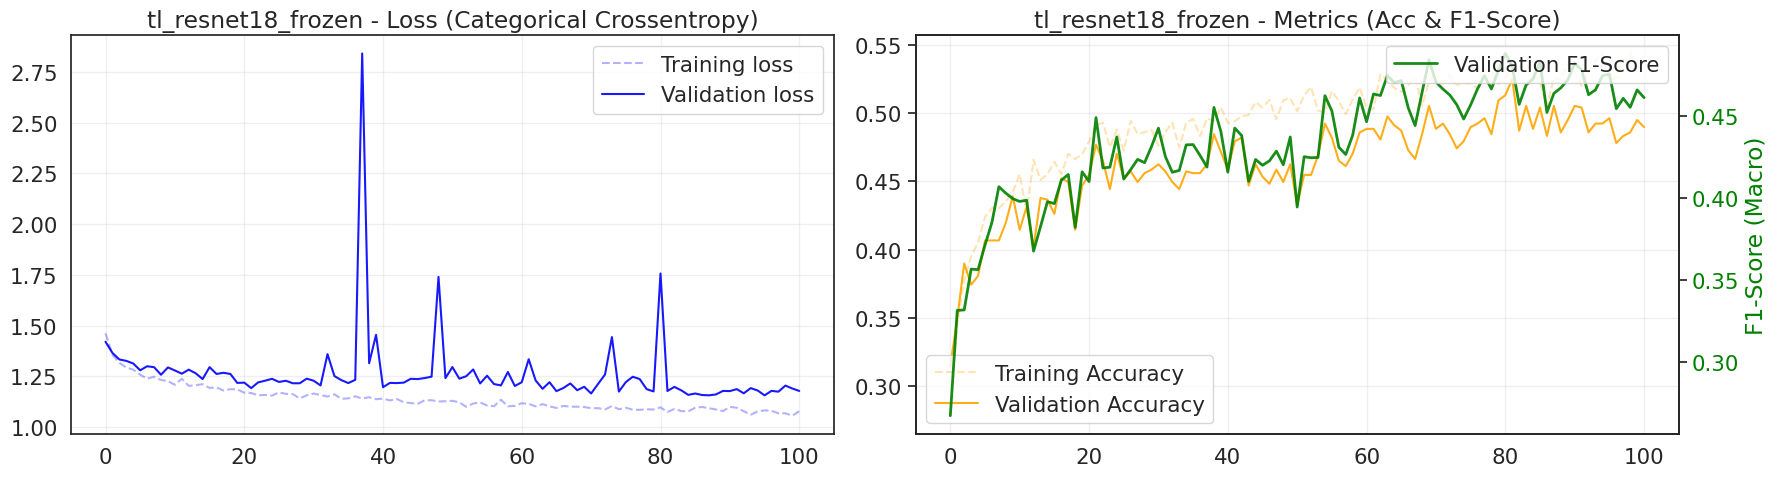

In [ ]:
# --- Evaluation and Plotting ---

final_val_f1 = round(max(tl_history['val_f1']) * 100, 2)
print(f'\nFinal best validation F1-Score: {final_val_f1}%')


# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='blue', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color='blue')
ax1.set_title(f'{experiment_name} - Loss (Categorical Crossentropy)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of validation F1-Score (The COMPETITION METRIC) and Accuracy on the second axis
ax2.plot(tl_history['train_acc'], label='Training Accuracy', alpha=0.3, color='orange', linestyle='--')
ax2.plot(tl_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='orange')
# F1-Score on a secondary axis (optional, but informative)
ax2_f1 = ax2.twinx()
ax2_f1.plot(tl_history['val_f1'], label='Validation F1-Score', alpha=0.9, color='green', linewidth=2)
ax2_f1.set_ylabel('F1-Score (Macro)', color='green')
ax2_f1.tick_params(axis='y', labelcolor='green')

ax2.set_title(f'{experiment_name} - Metrics (Acc & F1-Score)')
ax2.legend(loc='lower left')
ax2_f1.legend(loc='upper right')
ax2.grid(alpha=0.3)


# Adjust the layout and display the plot
plt.tight_layout()
plt.show()